**Natural Language Processing Song Lyrics**

<!--**Goal.** Use machine learning to predict the mood of music from song lyrics and audio features.-->

The following project aims to extract and analyze insightful data about songs from a specified playlist on Spotify using the Spotify Web API. Subsequently, the `lyricsgenius` package allows for web scraping of the Genius Lyrics website to extract the lyrics for each song. Following extraction, the lyrics are thoroughly cleaned before undergoing sentiment analysis.



In [1]:
import pandas as pd
from IPython.core.display import HTML
from IPython.display import set_matplotlib_formats
import seaborn as sns
import matplotlib.pyplot as plt

all_tracks = pd.read_csv("assets/data/all_tracks.csv", index_col=False)
all_tracks_with_lyrics = pd.read_csv("assets/data/all_tracks+lyrics.csv", index_col=False)

In [2]:
## Set Default Plot Chart Style Configurations
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = (8, 5) # Set default figure size.
plt.rc('font', family='Roboto') # Set default font family

pd.set_option('display.max_colwidth', None)
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=.5, rc={"grid.linewidth": 0.6})
sns.set_style({'font.family': 'Roboto'})

## Extracting Spotify Data

Getting started, we want to extract data for a set of tracks within one of Spotify's top-featured playlists. Leveraging the **Spotify Web API**, we can seamlessly obtain detailed data for a song, such as the performing artist, the album it belongs to, its release date, popularity, and audio features like danceability, energy, and tempo. 

Python libraries like `spotipy` offer a user-friendly way to interact with the Spotify API, offering a range of functions that streamline tasks like API authentication, retrieving playlist data, and obtaining information about any given song.


### Accessing the Spotify Web API

To access data from Spotify, we import the `spotipy` library and the `SpotifyClientCredentials` module. Additionally, we utilize the `pandas` package for data manipulation and display. In order to authenticate our access to the Spotify API, we must provide our **client ID** and **client secret** to a client credentials manager. Once authenticated, we can use the spotipy module to interact with the Spotify API and retrieve data.


In [3]:
import spotipy  # <1>
from spotipy.oauth2 import SpotifyClientCredentials  # <1>

client_id = "xxx"  # <2>
client_secret = "xxx"  # <2>
my_auth = SpotifyClientCredentials(client_id, client_secret)  # <3>
sp = spotipy.Spotify(auth_manager=my_auth)  # <4>

In [4]:
client_id = "3899576b5fcb4c458beba2cce99aa1b6"
client_secret = "4f57df7614df4f75b54364bf3c3018fd"
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id, client_secret))

#### Spotify's Featured Playlists

Let's take a look at the popular Spotify playlists. Below, the code retrieves a range of Spotify playlists and generates a dataframe containing details for each playlist, such as its name, ID, description, thumbnail, and total number of tracks. The resulting dataframe is displayed as an HTML table.

In [5]:
username = "spotify"
my_playlists = sp.user_playlists(username)

In [6]:
playlist_df = []
# Loop through list of response dictionaries
for item in my_playlists["items"]:
    playlist_id = item["id"]
    playlist_name = item["name"]
    description = item["description"]
    thumbnail = item["images"][0]["url"]
    total = item["tracks"]["total"]
    playlist_df.append([thumbnail, playlist_name, playlist_id, description, total])

playlist_df = pd.DataFrame(playlist_df, columns=["thumbnail", "playlist_name", "playlist_id", "description", "total"], ).head()

# Converting links to html tags
def path_to_image_html(path):
    return f'<img src="{path}" width="40" >'

# Rendering the dataframe as HTML table
HTML(playlist_df.to_html(escape=False, formatters=dict(thumbnail=path_to_image_html)))

---------------------

### Extracting Tracks From a Playlist

The script enables the compilation of song and artist data from any Spotify playlist through its URI. The `get_playlist_tracks` method returns a complete list of track IDs and corresponding artists from the selected playlist.

In [7]:
def get_playlist_tracks(playlist_URI):
    tracks = []
    results = sp.playlist_tracks(playlist_URI)
    tracks = results["items"]
    while results["next"]:
        results = sp.next(results)
        tracks.extend(results["items"])
    return tracks

#### Extracting Features from Tracks


Next, we utilize Spotify's API to extract further details about each song within the playlist. We obtain metadata such as the track name, the artist it's sung by, the album it belongs to, the release date, and track features such as danceability, tempo, and popularity.


In [8]:
all_tracks.head(2)

name                track_id             album          artist  \
0  Beautiful Things  6tNQ70jh4OwmPGpYy6R2o9  Beautiful Things    Benson Boone   
1          obsessed  6tNgRQ0K2NYZ0Rb9l9DzL8    GUTS (spilled)  Olivia Rodrigo   

                artist_id release_date  length  popularity  artist_pop  \
0  22wbnEMDvgVIAGdFeek6ET   2024-01-18  180304         100          84   
1  1McMsnEElThX1knmY4oliG   2024-03-22  170541          79          89   

               artist_genres  ...  instrumentalness  liveness  loudness  \
0  ['singer-songwriter pop']  ...               0.0     0.140    -5.692   
1                    ['pop']  ...               0.0     0.305    -5.094   

   speechiness    tempo  valence  key  mode  time_signature          playlist  
0       0.0603  105.029    0.219   10     1               3  Today’s Top Hits  
1       0.0915  119.985    0.697    8     1               4  Today’s Top Hits  

[2 rows x 23 columns]

#### Top Artist Genres



In [9]:
genres_dict = {}
for x in all_tracks.artist_genres:
    # Converting string to list
    res = x.replace("'", "").strip('][').split(', ')
    for genre_i in res:
        if genre_i in genres_dict:
            genres_dict[genre_i] += 1
        else:
            genres_dict[genre_i] = 1

# Convert Dictionary to Dataframe
df_genres = pd.DataFrame(genres_dict.items(), columns=['Genre', 'Freq']).sort_values('Freq', ascending=False)
df_genres = df_genres.reset_index(drop = True)

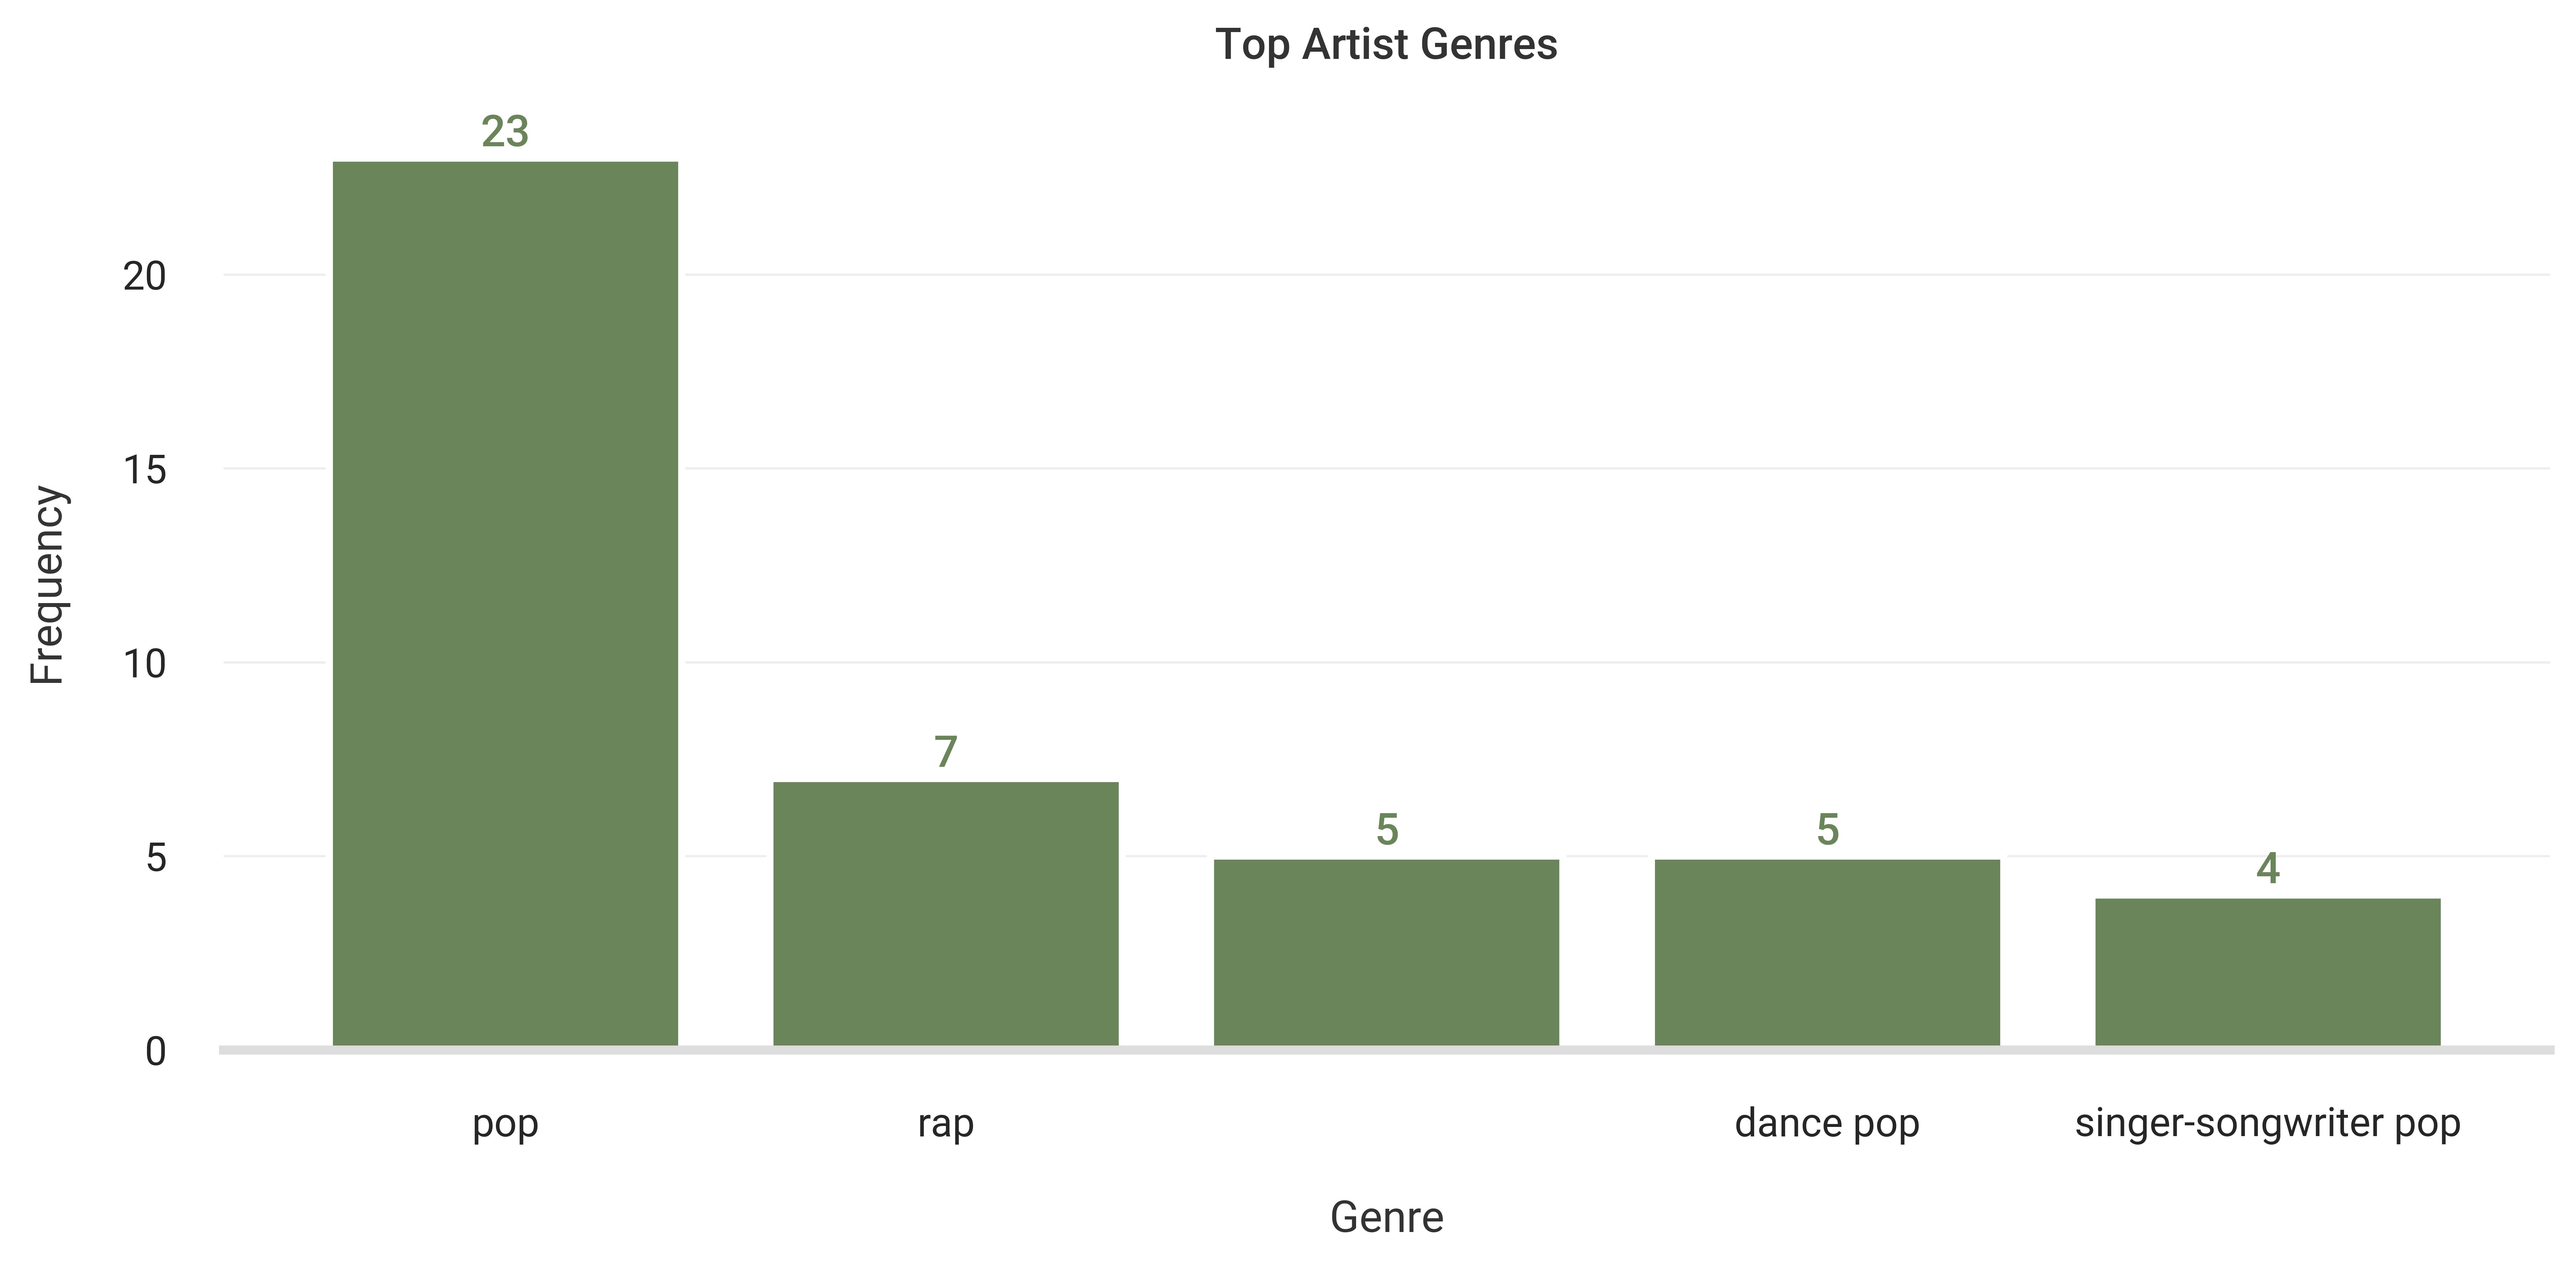

In [10]:
fig, ax = plt.subplots(figsize = (10,5), dpi =400)

# Save the chart so we can loop through the bars below.
bars = ax.bar(x=df_genres.head()['Genre'], height=df_genres.head()['Freq'],color="#6A8559")

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add text annotations to the top of the bars.
bar_color = bars[0].get_facecolor()
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.3,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

# Add labels and a title.
ax.set_xlabel('Genre', labelpad=15, color='#333333')
ax.set_ylabel('Frequency', labelpad=15, color='#333333')
ax.set_title('Top Artist Genres', pad=15, color='#333333',
             weight='bold')

fig.tight_layout()
# plt.savefig("static/images/artist_genres.png", format="png", dpi=1200)

In [11]:
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

df_genres2 = df_genres.head(15)

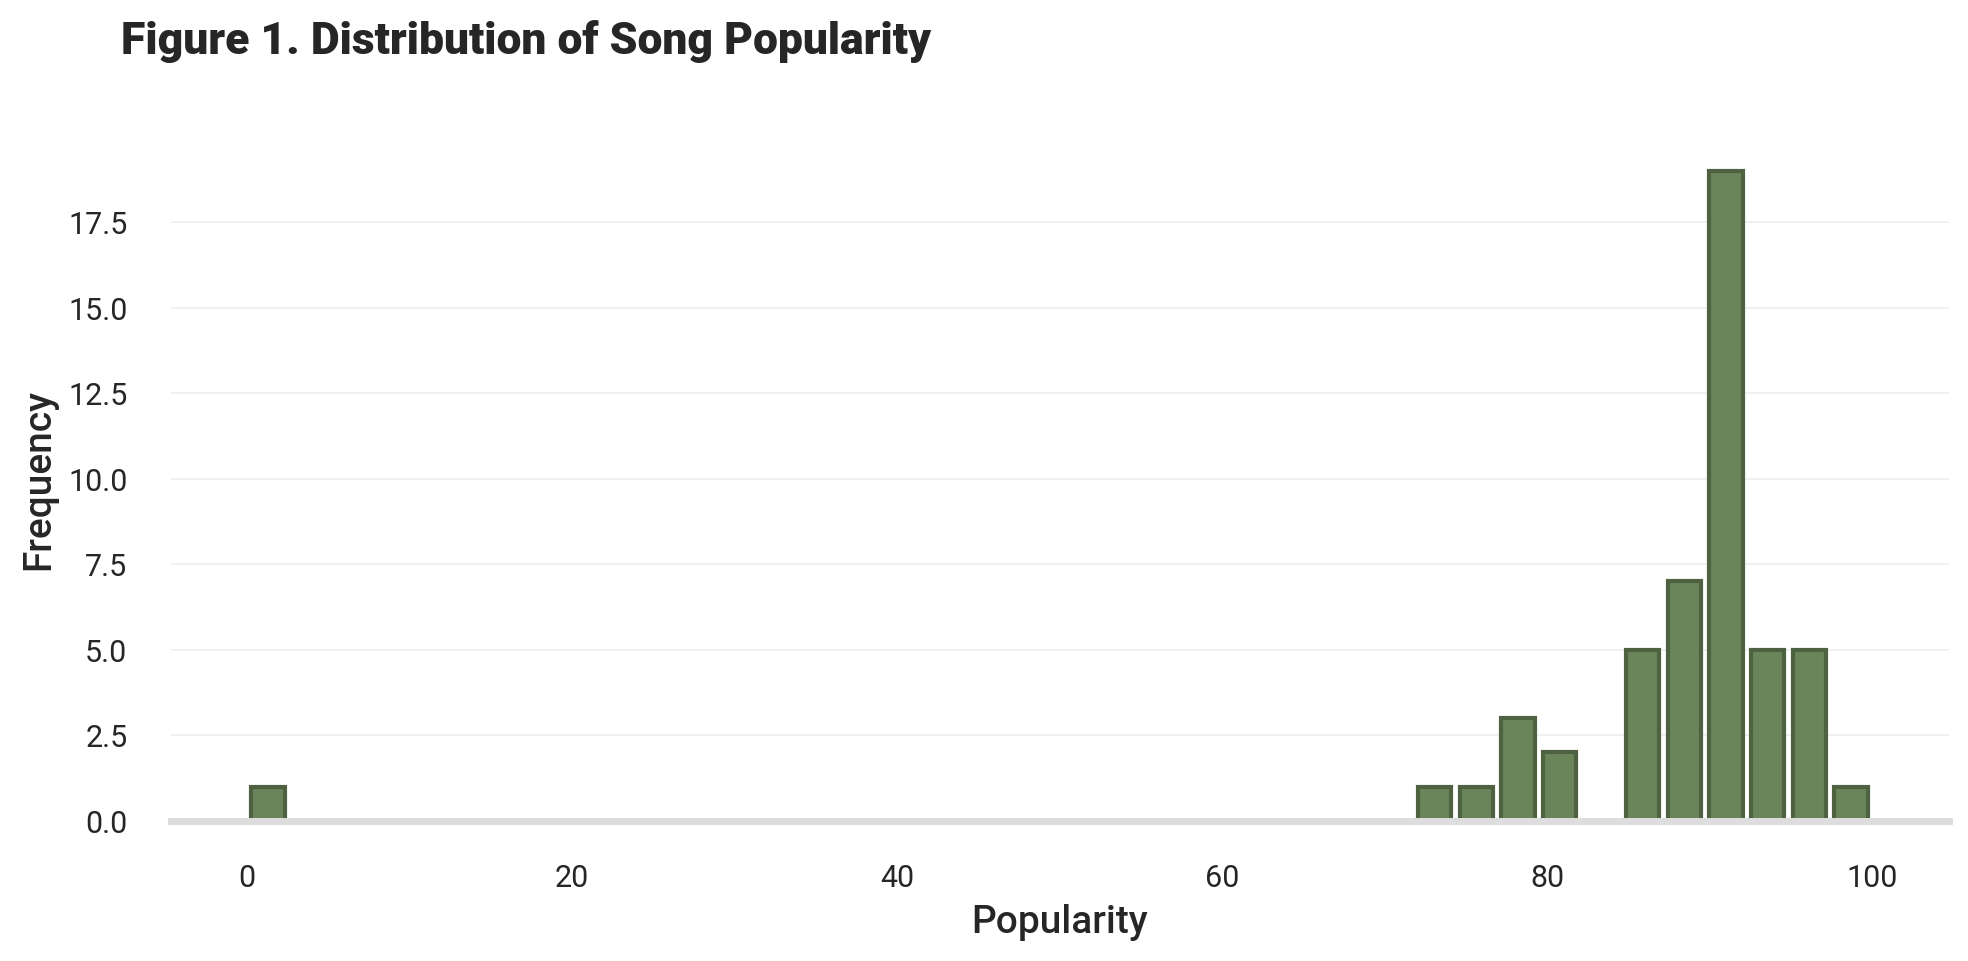

In [12]:
fig_hist = plt.figure(figsize = (10,5), dpi =100)
plt.title("Figure 1. Distribution of Song Popularity", weight='heavy',y =1.1, x=0.2).set_fontsize('16')
z = sns.histplot(data=all_tracks, x="popularity", color="#6A8559", alpha = 1.0, edgecolor="#4E6241", linewidth=1.5, shrink=.8)
sns.despine(left=True, bottom=False)
z.spines['bottom'].set_color('#DDDDDD')
z.yaxis.grid(True, color='#EEEEEE')
z.xaxis.grid(False)
plt.xlabel("Popularity", size=14, weight=500)
plt.ylabel("Frequency", size=14, weight=500)
plt.tight_layout()
# plt.savefig("static/images/hold_times_dist.png", format="png", dpi=1200)
plt.show()

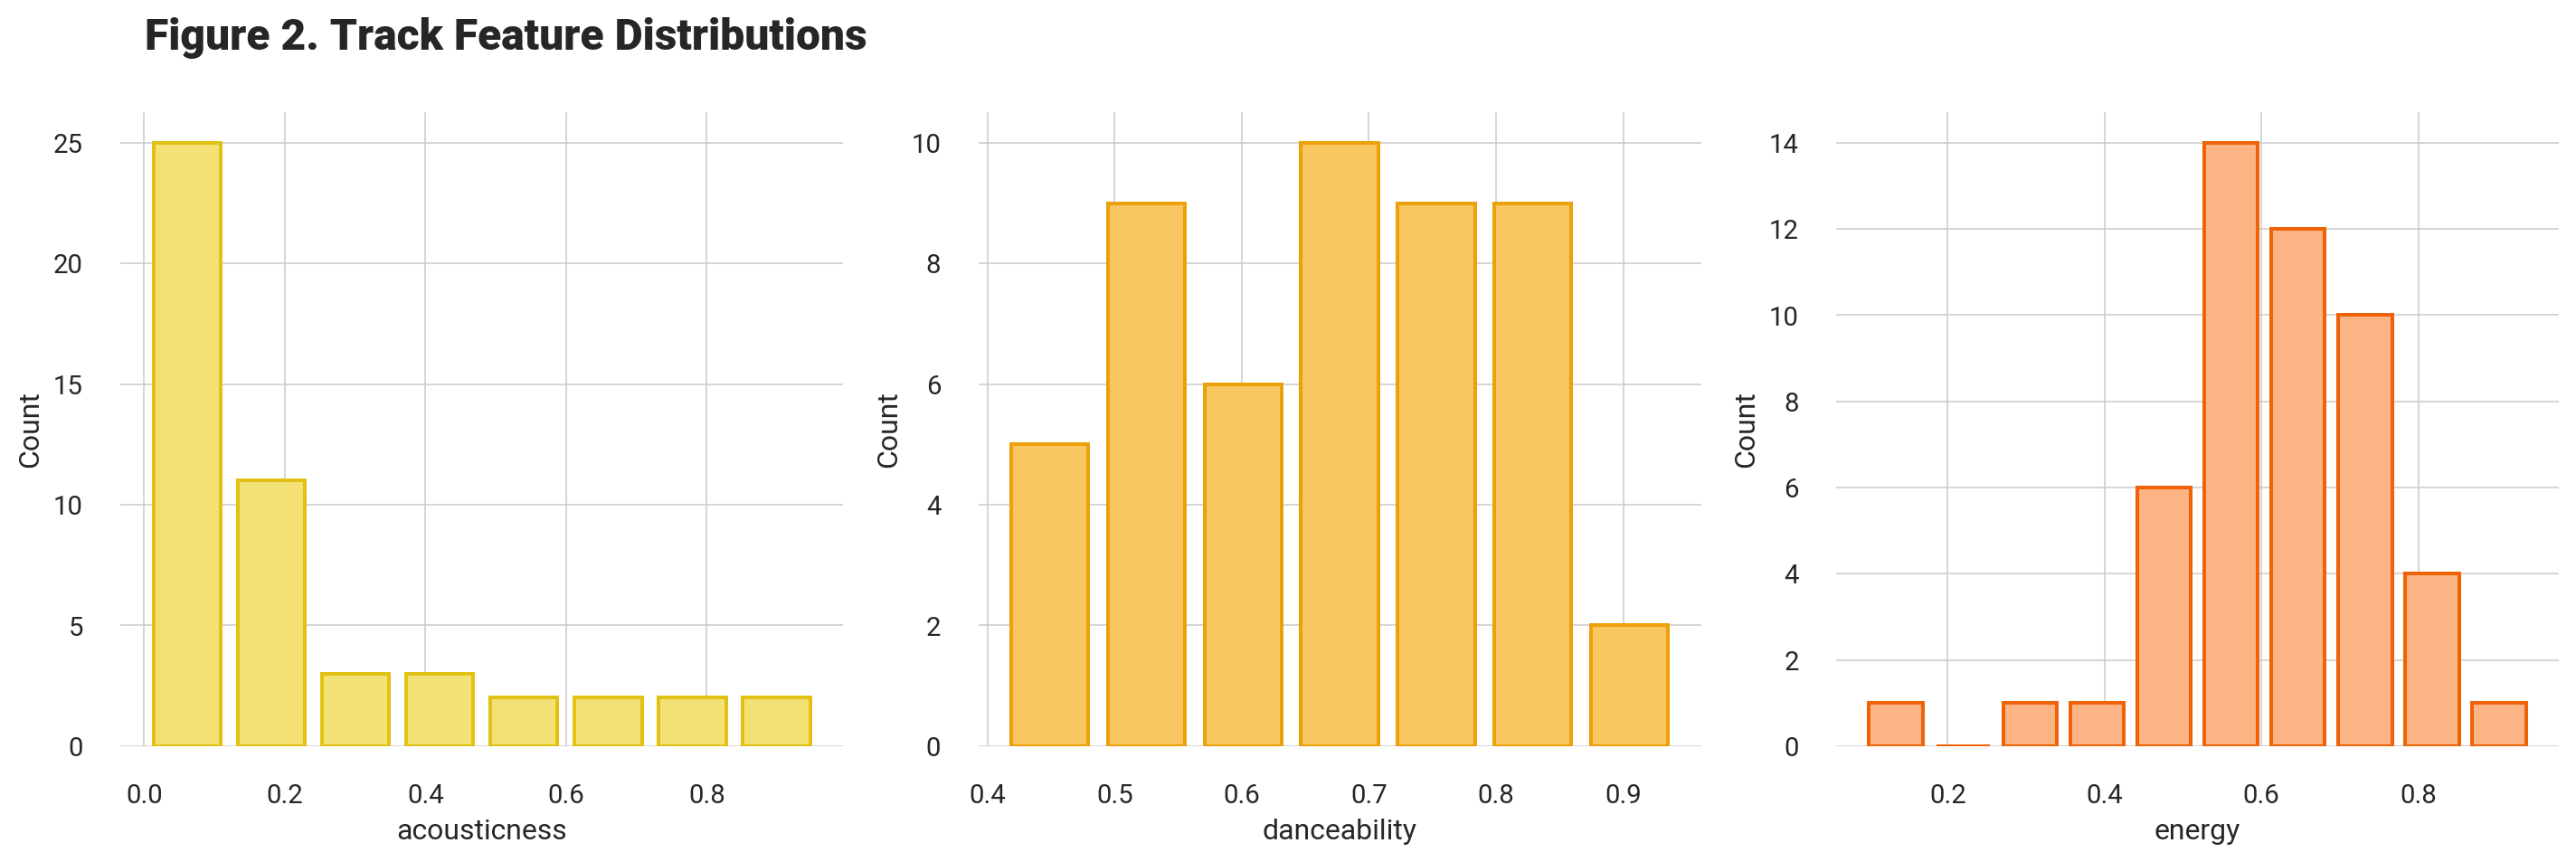

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Figure 2. Track Feature Distributions", weight="heavy", y=0.99, x=0.2).set_fontsize("18")

sns.histplot(data=all_tracks, x=all_tracks[all_tracks["acousticness"].notnull()]["acousticness"], color="#F3E176", alpha=1.0, ax=axs[0], edgecolor="#E1C214", linewidth=1.5, shrink=.8)
sns.histplot(data=all_tracks, x=all_tracks[all_tracks["danceability"].notnull()]["danceability"], color="#F9C762", alpha=1.0, ax=axs[1], edgecolor="#ECA009", linewidth=1.5, shrink=.8)
sns.histplot(data=all_tracks, x=all_tracks[all_tracks["energy"].notnull()]["energy"], color="#FCB484", alpha=1.0, ax=axs[2], edgecolor="#EF6306", linewidth=1.5, shrink=.8)

#axs[2].set_title("Positive")

sns.despine(left=True, bottom=True)
fig.tight_layout()
# plt.savefig("static/images/brand_dist.png", format="png", dpi=1200)
plt.show()

-------


## Natural Language Processing

Using the data gathered from the Spotify API, we now want to extract and process the lyrics for each song. This is accomplished through scraping textual information, namely lyrical data, from the **Genius Lyrics** website. Following extraction, the lyrics are thoroughly processed and cleaned before undergoing sentiment analysis. 



<!--### Scraping the Genius Lyrics Website
scraping textual information
Scraping the Genius Lyrics Website-->




### Scraping the Web

To get started, the script below imports `lyricsgenius`, a fundamental package libary allowing for web scraping of the Genius Lyrics website to retrieve the lyrics of any given song. Through the initialization of the `genius` variable, one can access the Genius API and retrieve the lyrics of any given song, such as "Too Many Nights" by Metro Boomin.


In [14]:
import lyricsgenius

genius = lyricsgenius.Genius("epFCxujgBe-Y6WrkZedI8kerKxiCpR6Rh0DAHYNlKDf9B4H1nXTdZIkj7krNUHVV")
song = genius.search_song("Too Many Nights", "Metro Boomin")

Searching for "Too Many Nights" by Metro Boomin...


Done.


We define a function to efficiently fetch the lyrics of a song using the given track name and artist. Once the lyrics are retrieved, the next step is to pre-process the textual data. This involves a cleansing process to eliminate profanity, specific characters, and patterns that may hinder the overall readability. The resulting output is a list of cleaned lyrics with all non-ASCII characters removed.


### Pre-Processing Text Data


The Python script contains various functions optimized for efficiently cleaning song lyrics.  The text pre-processing procedure involves the following main steps:

1. Language Detection
2. Expanding Contractions
3. Converting Text to Lowercase
4. Spell Checking + Censoring
5. Removing Punctuations
6. Tokenization

In [15]:
#| code-annotations: hover

def clean_song_lyrics(song_name, artist_name):
    genius_lyrics = get_song_lyrics(song_name, artist_name) # <1>
    lyrics_en = detect_and_translate(genius_lyrics, "en") # <2>

    no_contract = [contractions.fix(word).lower() for word in lyrics_en.split()] # <3>
    corrected = spell_check(" ".join(no_contract)) # <4> # Spell Check + Censor
    censored = profanity.censor(" ".join(corrected), censor_char="") # <4>
    no_punct = remove_punctuation(censored) # <5>

    tokenized = word_tokenize(no_punct) # Tokenize # <6>
    return [i.encode("ascii", "ignore").decode() for i in tokenized]

The `clean_song_lyrics` function is designed to simplify the processing of lyrics for a specific song and artist. The function extracts the lyrics from the Genius database and performs a series of modifications, including expanding contractions, removing repetitive phrases, and converting the text to lowercase. It also ensures that the spelling is correct and eliminates any profanity. The end result is a cleaned set of lyrics, tokenized and encoded as a list of words.

#### Further Text Cleaning


**`Removing Stop Words:`** We employ the Natural Language Toolkit (*NLTK*) library and its `WordNetLemmatizer` tool to filter out stopwords. By removing frequently used words like "the," "and," or "of," the resulting text becomes more concise, enabling a more thorough examination of the lyrics and their underlying message.

**`Lemmatization:`** We perform lemmatization on a set of words using the `WordNetLemmatizer` class from the NLTK library. Lemmatization helps to standardize words and reduce their complexity. Our function specifically targets verbs and transforms different variations of the same verb into its most basic form.

See the full documentation [here]("01_sentiment_analysis/02_nlp.ipynb").


#### Exploratory text analysis



In [16]:
pd.options.display.max_colwidth = 55
df_lyrics = all_tracks_with_lyrics[['name',  'artist', 'lyrics', 'stopwords_removed', 'lemmatized']]
df_lyrics.head(3)

name          artist  \
0                          Beautiful Things    Benson Boone   
1                                  obsessed  Olivia Rodrigo   
2  we can't be friends (wait for your love)   Ariana Grande   

                                                   lyrics  \
0  ['for', 'a', 'while', 'there', 'it', 'was', 'rough'...   
1  ['law', 'dada', 'data', 'lambda', 'law', 'dada', 'd...   
2  ['i', 'did', 'not', 'think', 'you', 'would', 'under...   

                                        stopwords_removed  \
0  ['rough', 'lately', 'better', 'last', 'four', 'cold...   
1  ['law', 'dada', 'data', 'lambda', 'law', 'dada', 'd...   
2  ['think', 'would', 'understand', 'could', 'ever', '...   

                                               lemmatized  
0  ['rough', 'lately', 'well', 'last', 'four', 'cold',...  
1  ['law', 'dada', 'data', 'lambda', 'law', 'dada', 'd...  
2  ['think', 'would', 'understand', 'could', 'ever', '...

##### Term Frequency Analysis

Let's examine the most frequent words. Plotting the frequency distribution helps to determine the occurrence of the most common terms in our lyrical corpus. Initially, we transform our individual lists of tokenized lyrics into a comprehensive list of iterable tokens that encompasses all the lyrics collectively.

In [17]:
from nltk.probability import FreqDist

all_words = []
for words in df_lyrics['lemmatized']:
    res = words.replace("'", "").strip('][').split(', ')
    all_words += res

mostcommon = FreqDist(all_words).most_common(30)

In [18]:
x_mostcommon, y_mostcommon = zip(*mostcommon)
fig = px.bar(x=x_mostcommon, y=y_mostcommon, text_auto='.2s',
            title="Term Frequency Analysis of Popular Lyrics",
            template='plotly_dark') # plotly_white
# fig.show()

In [19]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=x_mostcommon,
        y=y_mostcommon,
        text=y_mostcommon,
        marker_color="rgb(55, 83, 109)",  
        #orientation="h",
        textfont={"family": "Roboto", "size": 8, "color": "white"}
    )
)
fig.update_layout(
    title="Term Frequency Analysis of Popular Lyrics",
    title_font=dict(family="Roboto", size=17), #template="plotly_dark",
    xaxis=dict(title='Count',titlefont_size=12,tickfont_size=10),
    yaxis=dict(title='Frequency',titlefont_size=12,tickfont_size=12),
    barmode="group",
    bargap=0.15,  # gap between bars of adjacent location coordinates.
    bargroupgap=0.1,  # gap between bars of the same location coordinate.
)
fig.update_traces(marker_color= '#6A8559', 
                  marker_line_color='#4E6241',
                  marker_line_width=1.25, opacity=0.996)

fig.show()

--------------


## Sentiment Analysis


Subsequently, the process involves the implementation of pipeline classes to carry out predictions using models accessible in the Hub. The code imports and employs multiple transformer models specifically designed for text classification and sentiment analysis. Specifically, the following procedure creates three distinct pipelines, each equipped with different models that facilitate the assessment of emotions and sentiment in textual content.


In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
import transformers
from transformers import pipeline

# Initialize Genius API and sentiment classifiers
classifiers = [
    pipeline("text-classification", model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True),
    pipeline("text-classification", model='cardiffnlp/twitter-roberta-base-sentiment', return_all_scores=True),
    pipeline("sentiment-analysis", return_all_scores=True)
]

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


The `get_lyric_sentiment` function takes in pre-processed lyrics as input and produces a dictionary of sentiment scores. It leverages three distinct classifiers to calculate the scores and aggregates them into a final result. For instance, one of these classifiers is the *distilbert-base-uncased-emotion* model, specifically trained to detect "emotions in texts such as sadness, joy, love, anger, fear, and surprise".


In [22]:
# Function to perform sentiment analysis
def get_lyric_sentiment(lyrics, classifiers):
    text = " ".join(lyrics)
    scores = {}
    for classifier in classifiers:
        try:
            predictions = classifier(text, truncation=True)
            for prediction in predictions[0]:
                scores[prediction["label"]] = prediction["score"]
        except Exception as e:
            print(f"Error during sentiment analysis: {e}")
    return scores

---------------------


## Putting it All Together


To summarize, the code efficiently collects data and performs text analysis on every song in a playlist. Specifically, it systematically processes a list of tracks and corresponding artists while simultaneously conducting a thorough cleaning procedure on the lyrics. Additionally, the program computes a sentiment score for each song based on the lyrics, indicating whether the lyrics are positive, negative, or neutral. 


In [23]:
# all_tracks_with_lyrics.head(2)
df_final = all_tracks_with_lyrics[['name', 'album', 'artist', 'release_date',
       'length', 'popularity', 'artist_pop', 'artist_genres', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence', 'key', 'mode', 'time_signature',
       'playlist', 'sadness', 'joy', 'love', 'anger', 'fear', 'surprise',
       'LABEL_0', 'LABEL_1', 'LABEL_2', 'NEGATIVE', 'POSITIVE']]

df_final.head(3)

name             album          artist  \
0                          Beautiful Things  Beautiful Things    Benson Boone   
1                                  obsessed    GUTS (spilled)  Olivia Rodrigo   
2  we can't be friends (wait for your love)  eternal sunshine   Ariana Grande   

  release_date  length  popularity  artist_pop              artist_genres  \
0   2024-01-18  180304         100          84  ['singer-songwriter pop']   
1   2024-03-22  170541          79          89                    ['pop']   
2   2024-03-08  228639          88          94                    ['pop']   

   acousticness  danceability  ...       joy      love     anger      fear  \
0        0.1510         0.472  ...  0.000454  0.000210  0.000819  0.996218   
1        0.0219         0.683  ...  0.000476  0.000644  0.000680  0.003106   
2        0.0716         0.647  ...  0.992336  0.001261  0.001286  0.000605   

   surprise   LABEL_0   LABEL_1   LABEL_2  NEGATIVE  POSITIVE  
0  0.000817  0.033695  0.346160  0.620145  0.012751  0.987248  
1  0.000368  0.301736  0.594620  0.103644  0.994116  0.005884  
2  0.000460  0.063339  0.507926  0.428735  0.996296  0.003704  

[3 rows x 32 columns]

In summary, the above code aims to collect and refine song lyrics by eliminating stopwords and conducting lemmatization. Subsequently, it employs pre-trained models for sentiment analysis to determine the prevailing emotion conveyed in the lyrics. Finally, the program compiles all this information into a dataframe for further analysis.


----

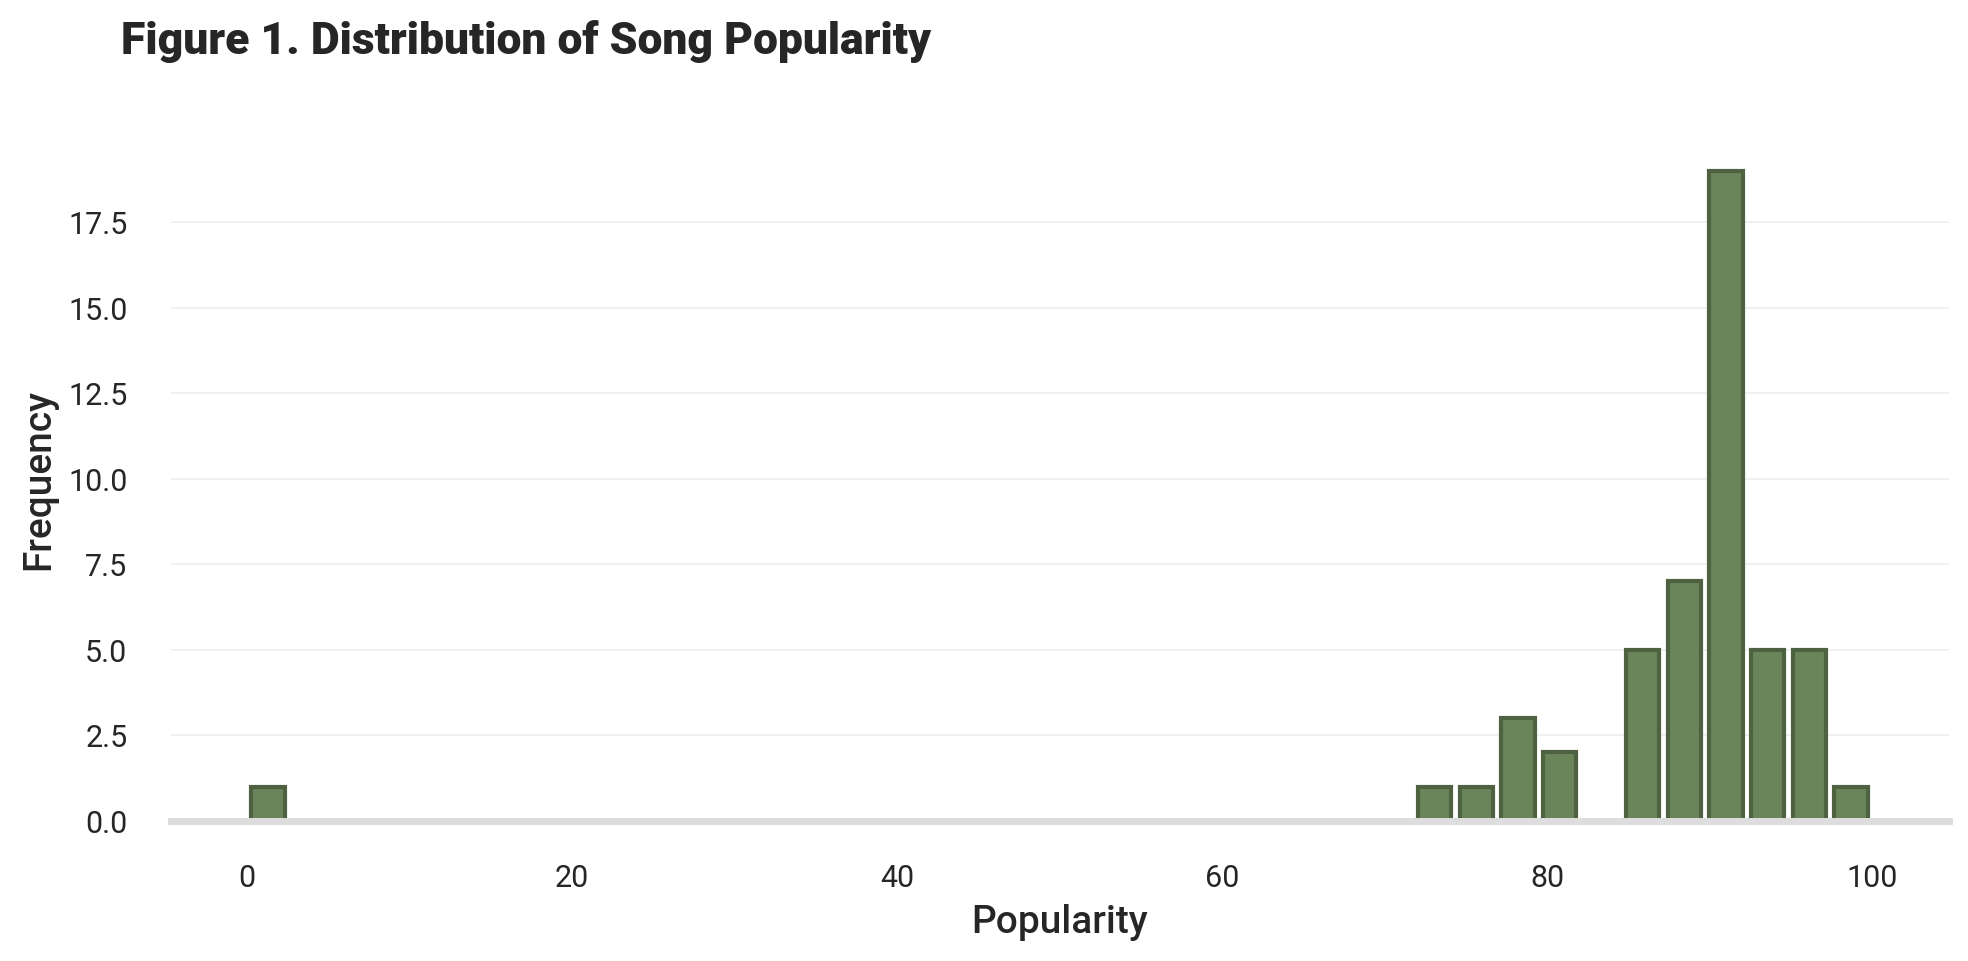

In [24]:
fig_hist = plt.figure(figsize = (10,5), dpi =100)
plt.title("Figure 1. Distribution of Song Popularity", weight='heavy',y =1.1, x=0.2).set_fontsize('16')
z = sns.histplot(data=df_final, x="popularity", color="#6A8559", alpha = 1.0, edgecolor="#4E6241", linewidth=1.5, shrink=.8)
sns.despine(left=True, bottom=False)
z.spines['bottom'].set_color('#DDDDDD')
z.yaxis.grid(True, color='#EEEEEE')
z.xaxis.grid(False)
plt.xlabel("Popularity", size=14, weight=500)
plt.ylabel("Frequency", size=14, weight=500)
plt.tight_layout()
# plt.savefig("static/images/hold_times_dist.png", format="png", dpi=1200)
plt.show()

In [25]:
#plotly_fig2 = tls.mpl_to_plotly(fig_hist) ## convert 
#iplot(plotly_fig2)

#### Twitter-roBERTa-base for Sentiment Analysis

Now, we present a graphical representation of the results obtained from the *roBERTa-base* model "trained on roughly 58 million tweets and fine-tuned for sentiment analysis using the TweetEval benchmark" (EMNLP 2020). According to the **TweetEval** reference paper and official Github repository, the resulting labels `0`, `1`, and `2` correspond to Negative, Neutral, and Positive, respectively.

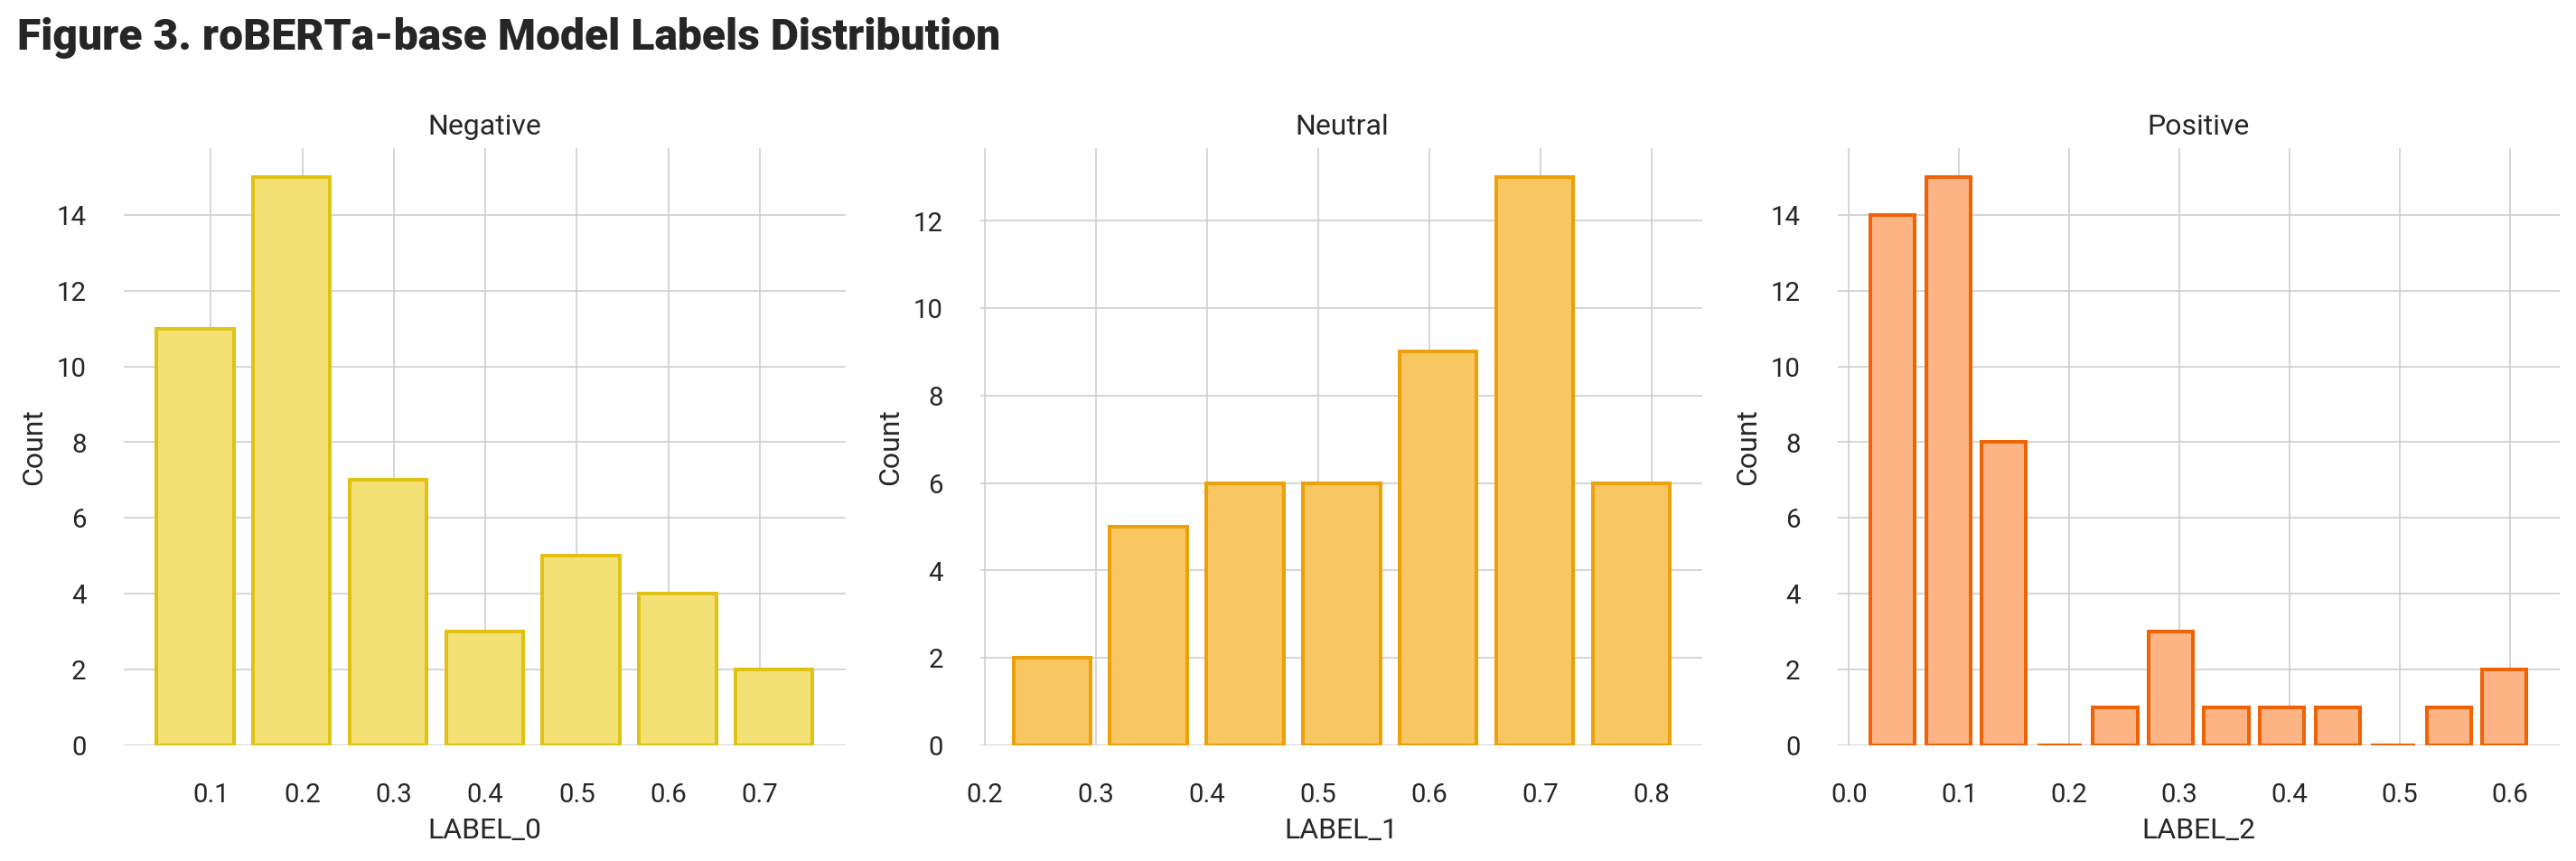

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Figure 3. roBERTa-base Model Labels Distribution", weight="heavy", y=0.99, x=0.2).set_fontsize("18")

sns.histplot(data=df_final, x=df_final[df_final["LABEL_0"].notnull()]["LABEL_0"], color="#F3E176", alpha=1.0, ax=axs[0], edgecolor="#E1C214", linewidth=1.5, shrink=.8)
axs[0].set_title("Negative")
sns.histplot(data=df_final, x=df_final[df_final["LABEL_1"].notnull()]["LABEL_1"], color="#F9C762", alpha=1.0, ax=axs[1], edgecolor="#ECA009", linewidth=1.5, shrink=.8)
axs[1].set_title("Neutral")
sns.histplot(data=df_final, x=df_final[df_final["LABEL_2"].notnull()]["LABEL_2"], color="#FCB484", alpha=1.0, ax=axs[2], edgecolor="#EF6306", linewidth=1.5, shrink=.8)
axs[2].set_title("Positive")

sns.despine(left=True, bottom=True)
fig.tight_layout()
# plt.savefig("static/images/brand_dist.png", format="png", dpi=1200)
plt.show()

------------------------------------


## Correlations Matrix

After completing the initial data analysis, we proceed with generating the Pearson correlations matrix using the Pandas command `df.corr()`. Subsequently, we visualize the matrix using the seaborn heatmap, providing a detailed understanding of the relationships between the various variables in our dataset.


In [27]:
track_sentiment_df = df_final[['name', 'artist',
           'acousticness', 'danceability', 'energy', 'instrumentalness', 
           'loudness', 'speechiness', 'tempo', 'valence', 
           'sadness', 'joy', 'love', 'anger', 'fear', 'surprise',
           'LABEL_0', 'LABEL_1', 'LABEL_2', 'NEGATIVE', 'POSITIVE']]

# Find the pearson correlations matrix
corr = track_sentiment_df.corr(method = 'pearson')

In [28]:
plt.figure(figsize=(10,8), dpi =600)
g = sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5, annot_kws={"size": 8}, cbar_kws={"shrink": .25})

g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 9,family='Roboto')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 9,family='Roboto')
plt.title('Sentiment Analysis Model Labels Correlation Matrix')

# plt.savefig('static/images/heatmap.png')              
plt.show()

In [29]:
#fig, ax = plt.subplots(figsize=(10,6))
#sns.heatmap(corr, center=0, cmap='Blues')
#ax.set_title('Multi-Collinearity of Lyric NLP Sentiment Analysis')

The code below produces a scatterplot that showcases the correlation between energy and fear. The x-axis represents the energy value, while the y-axis represents the fear sentiment. The size of each data point corresponds to the label indicating the neutral sentiment level, and its color represents the valence value. Moreover, each bubble contains its energy value within, allowing for a straightforward interpretation of the data.


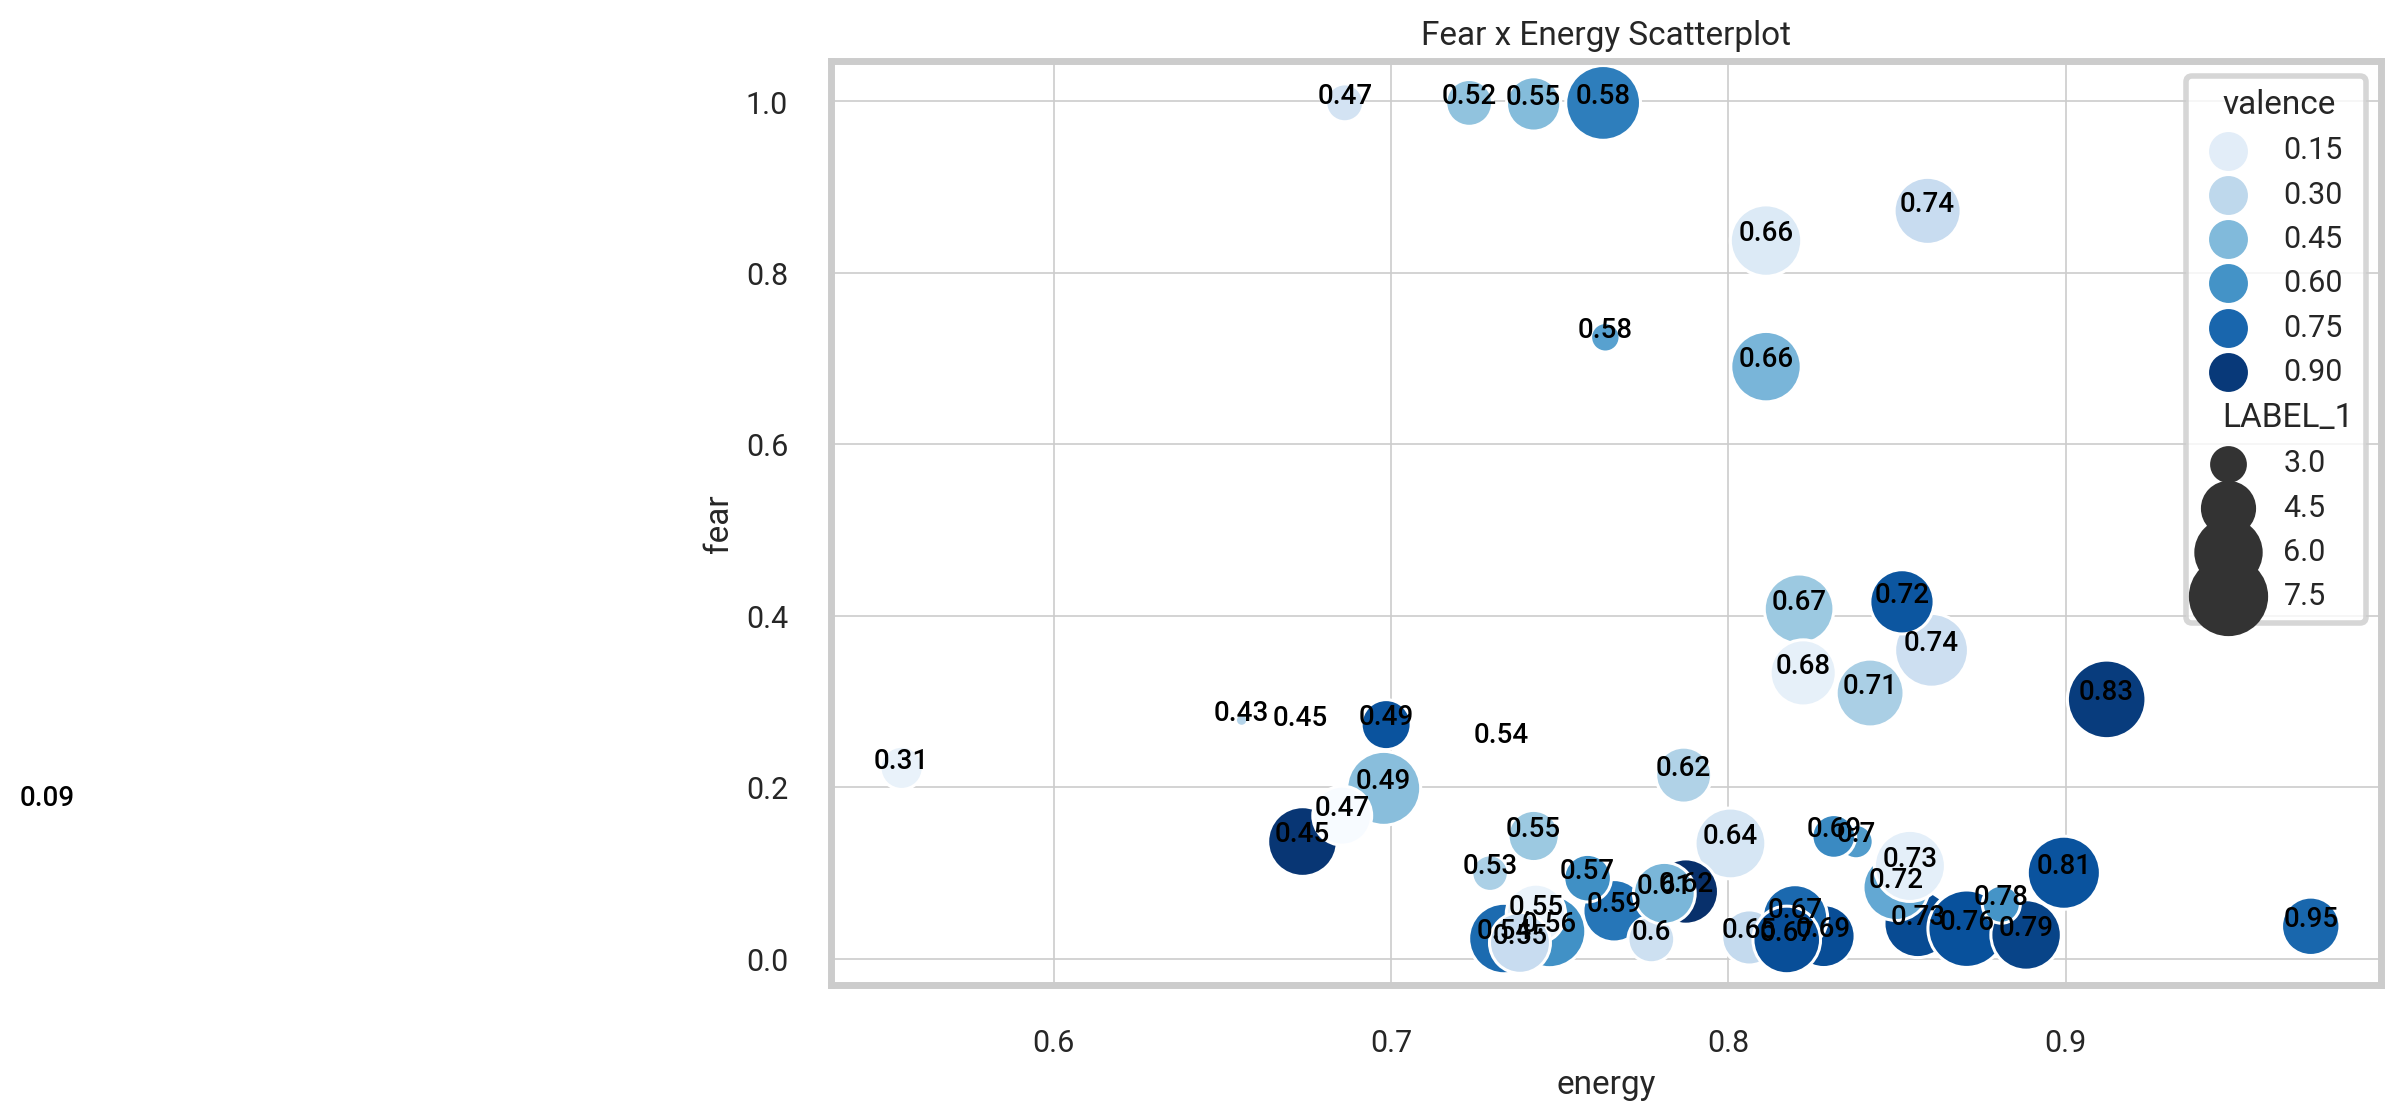

In [30]:
fig = plt.figure(figsize = (10,6), dpi=100)
# Create scatterplot. alpha controls the opacity and s controls the size.
ax = sns.scatterplot(x=track_sentiment_df['energy']**0.5, y=track_sentiment_df['fear']**0.5,
               size=track_sentiment_df['LABEL_1']*10, hue=track_sentiment_df['valence'],
               sizes=(20,800),
               palette='Blues')
#For each point, we add a text inside the bubble
for line in range(0,track_sentiment_df.shape[0]):
     ax.text(track_sentiment_df.energy[line]**0.5, track_sentiment_df.fear[line]**0.5, 
             round(track_sentiment_df.energy[line], 2), 
             horizontalalignment='center', size='small', color='black', weight='semibold')
        
plt.title('Fear x Energy Scatterplot')
#plt.savefig(title, dpi=400)
plt.show()

Text(0.5, 1.0, 'Fear vs. Energy')

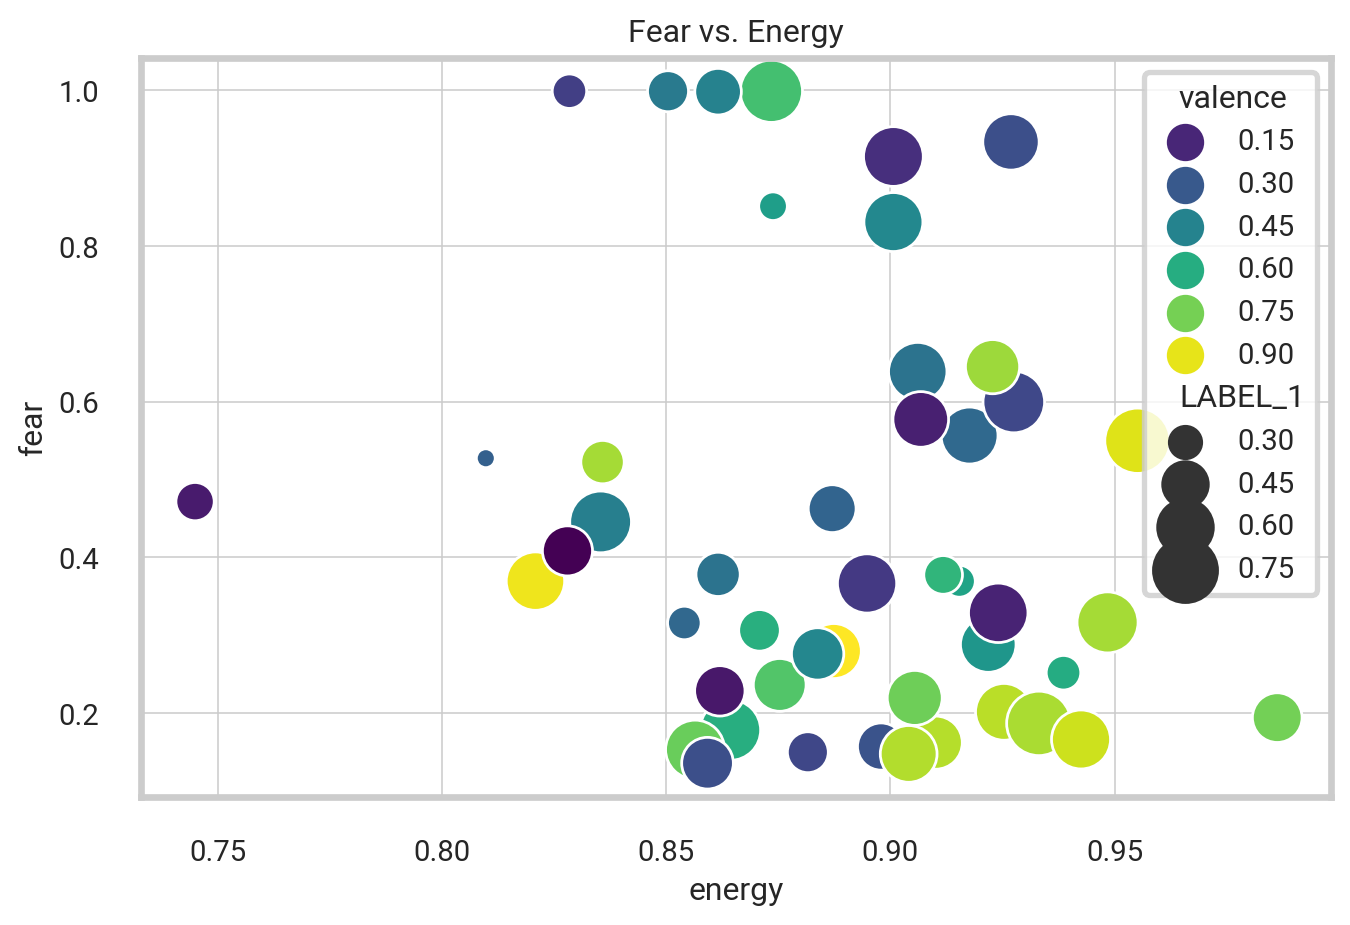

In [31]:
#fig = plt.figure(figsize = (10,6), dpi=800)
# Create scatterplot. alpha controls the opacity and s controls the size.
plot = sns.scatterplot(x = track_sentiment_df['energy']**0.25, 
                       y = track_sentiment_df['fear']**0.25,
                       hue = track_sentiment_df['valence'],
                       size = track_sentiment_df['LABEL_1'],
                       sizes = (50, 600),
                       size_order = track_sentiment_df['LABEL_1'],
                       palette = 'viridis')
plot.set_title('Fear vs. Energy')


Similarly, the scatterplot presented above utilizes the track sentiment data, comparing the energy and fear levels of the tracks based on valence and size.

------



## PCA Analysis

Next, we implement principal component analysis (PCA) on a comprehensive dataset comprising a range of musical features.

First, we create a table from the `df_final` dataframe by extracting specific columns that facilitate our analysis. These columns consist of acousticness, danceability, energy, speechiness, tempo, and valence of each track, as well as emotional features such as sadness, joy, love, anger, fear, and surprise. In addition, the table includes the track name and flags for both negative and positive sentiments.

We then perform PCA on the data in the table and apply it to generate a biplot depicting the relationship between the features and tracks. This biplot quickly reveals any discernible patterns and clusters within the dataset.


In [32]:
X_SMALL = df_final[['acousticness', 'danceability', 'energy', 'speechiness', 
                    'tempo', 'valence', 'sadness', 'joy', 'love', 'anger', 
                    'fear', 'surprise', 'name', 'NEGATIVE', 'POSITIVE']]

To process the data, the code employs the **PCA** and **StandardScaler** modules from the `sklearn` *decomposition* and *preprocessing* libraries. Specifically, the $X_i$ variable is used to choose the first 12 columns from the subset of data mentioned above, while the track_name column is chosen as the target variable. Next, the StandardScaler standardizes the $X_i$ data.

PCA is applied to the standardized data, $X_{st}$, using the PCA module, and the resulting loadings and eigenvalues are saved.

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from bioinfokit.visuz import cluster

X_i = X_SMALL.iloc[:,0:12]
target = X_SMALL['name'].to_numpy()
X_st =  StandardScaler().fit_transform(X_i)
pca_out = PCA().fit(X_st)

# component loadings
loadings = pca_out.components_

# get eigenvalues (variance explained by each PC)  
pca_out.explained_variance_

array([2.73922470e+00, 1.81872809e+00, 1.55361774e+00, 1.29202669e+00,
       1.11165244e+00, 1.03938832e+00, 8.09497570e-01, 6.42936686e-01,
       5.17927574e-01, 4.14876283e-01, 3.05021862e-01, 8.89034026e-15])

Next, the following code uses the `PCA()` function to calculate the PCA scores of the standardized data set, $X_{st}$. 

A biplot is generated using the cluster module from the bioinfokit library. The biplot is based on the PCA scores and loadings, and the column names of the $X_i$ data frame are used as labels for the plot. The variance explained by the first two principal components are also displayed on the plot.


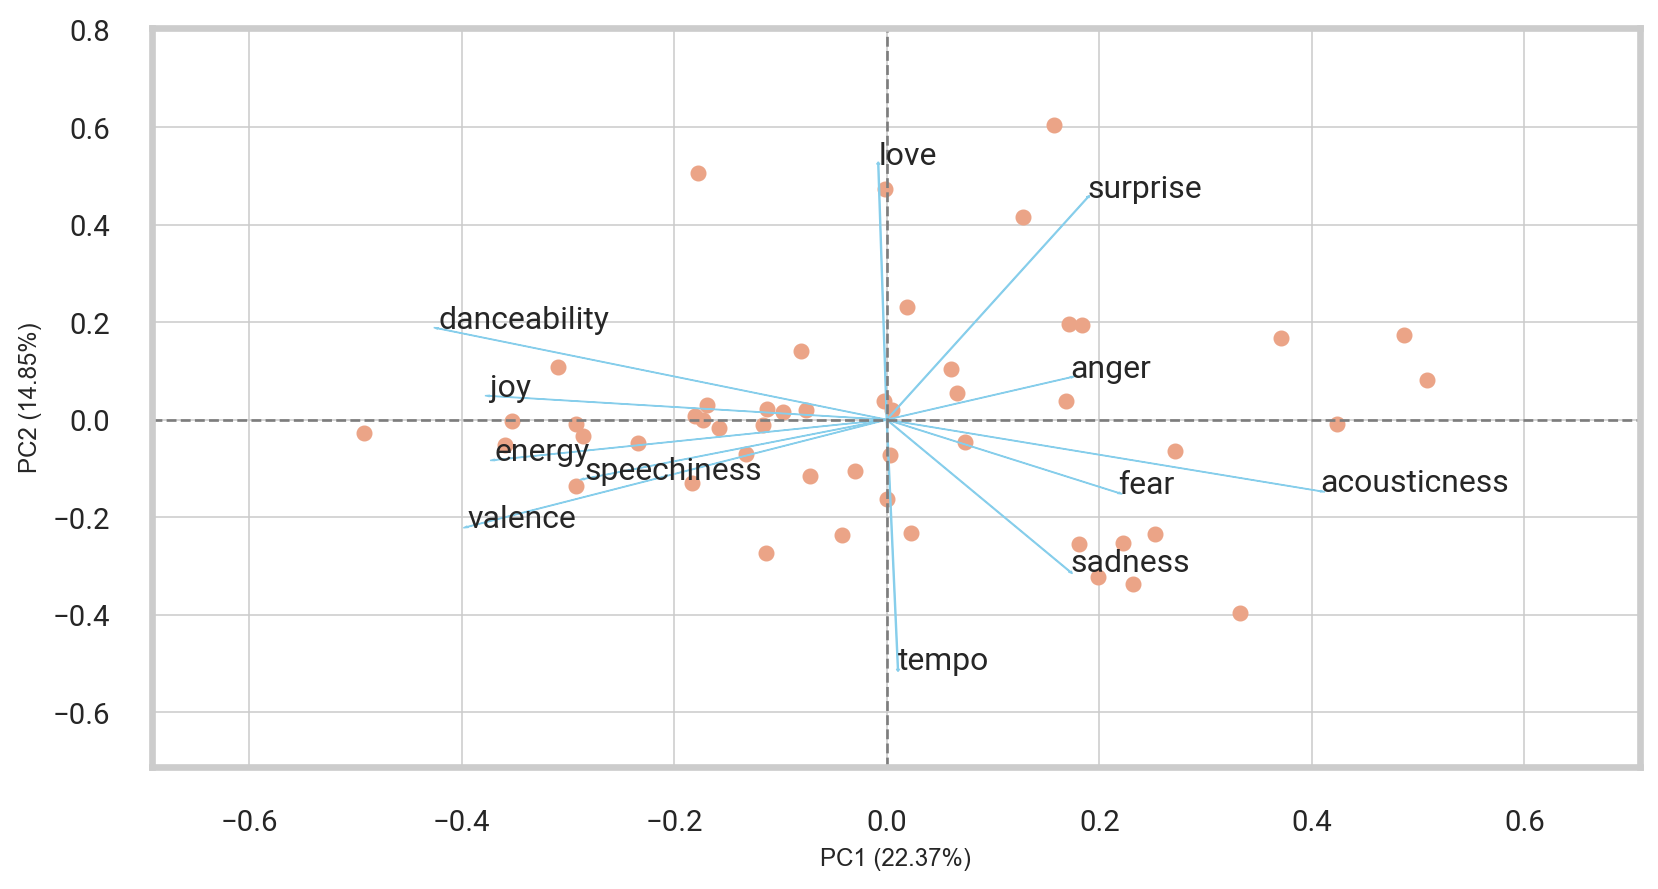

In [34]:
# get biplot
pca_scores = PCA().fit_transform(X_st)
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=X_i.columns.values, 
               var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
               var2=round(pca_out.explained_variance_ratio_[1]*100, 2), #colorlist=target,
               show=True,dim=(10,5),dotsize=16)



Then, I assigned the resulting column names to the variable `cols_pca` using a list comprehension. Using the PCA scores, column names, and the original index from $X_i$, I created a new pandas DataFrame called `df_pca`. The first three rows of this new DataFrame is shown below.

In [35]:
pca_scores = PCA().fit_transform(X_st)
cols_pca = [f'PC{i}' for i in range(1, pca_out.n_components_+1)]
df_pca = pd.DataFrame(pca_scores, columns=cols_pca, index=X_i.index)

In [36]:
df_pca.head(3)

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.968748 -0.421134  0.638886  2.608245 -1.238485  0.684002 -0.310952   
1 -0.308694 -1.537003 -1.668544 -1.290715 -1.273783 -0.477774  1.070345   
2 -0.819077  0.142560  1.177381  0.109127  0.103044 -0.814402 -1.344701   

        PC8       PC9      PC10      PC11          PC12  
0 -0.698681 -0.991042  0.091204 -0.897456  1.600704e-07  
1 -0.053149 -1.130636  0.337365 -0.805948 -6.780730e-08  
2 -0.562481 -0.607264  0.545114  0.293676 -9.294006e-08

The variance ratios for the PCA output and the cumulative sum of the explained variance ratios are printed below. Specifically, the array displayed represents the amount of variability explained by each component.

In [37]:
print(pca_out.explained_variance_ratio_)
print('----')
print(pca_out.explained_variance_ratio_.cumsum())

[2.23703351e-01 1.48529460e-01 1.26878782e-01 1.05515513e-01
 9.07849493e-02 8.48833796e-02 6.61089682e-02 5.25064960e-02
 4.22974186e-02 3.38815631e-02 2.49101188e-02 7.26044455e-16]
----
[0.22370335 0.37223281 0.49911159 0.60462711 0.69541206 0.78029544
 0.8464044  0.8989109  0.94120832 0.97508988 1.         1.        ]



The loading vectors help visualize the relationship between the original variables and their respective components. These vectors represent the weights of the variables within a mathematical equation used to generate the principal components.

In [38]:
df_weights = pd.DataFrame(pca_out.components_.T, columns=df_pca.columns, index=X_i.columns)
df_weights

PC1       PC2       PC3       PC4       PC5       PC6  \
acousticness  0.408035 -0.146674  0.184069 -0.305044 -0.168769  0.307214   
danceability -0.422117  0.187035 -0.143083 -0.057866 -0.124999  0.336009   
energy       -0.368829 -0.082644 -0.368905  0.203881  0.358443 -0.104268   
speechiness  -0.284747 -0.121462  0.306162 -0.039564 -0.115693  0.214292   
tempo         0.010528 -0.511718 -0.003009  0.187506  0.339350 -0.333285   
valence      -0.394459 -0.219710 -0.286606 -0.140502 -0.115587  0.257849   
sadness       0.172418 -0.311660 -0.428734 -0.441682 -0.205517 -0.264849   
joy          -0.373561  0.048629  0.557857 -0.157352  0.087738 -0.206966   
love         -0.007973  0.523938 -0.342743  0.064558 -0.243361 -0.149107   
anger         0.173068  0.086883 -0.134633 -0.219114  0.673753  0.524189   
fear          0.217856 -0.150010 -0.019676  0.730233 -0.184948  0.302261   
surprise      0.189071  0.455779  0.051612  0.017458  0.296982 -0.238771   

                   PC7       PC8       PC9      PC10      PC11          PC12  
acousticness -0.125811  0.160301  0.295463 -0.379955  0.537596  6.553177e-09  
danceability  0.148793  0.440103  0.011646  0.501877  0.408216 -2.788028e-09  
energy       -0.138360 -0.060305 -0.266860 -0.479832  0.464641  6.133656e-09  
speechiness   0.771135 -0.254452 -0.088982 -0.286787 -0.000522  8.034013e-09  
tempo         0.257478  0.068690  0.564378  0.247237  0.161144 -1.971415e-08  
valence      -0.155436  0.259498  0.403342 -0.335007 -0.497981  1.801651e-09  
sadness       0.229241  0.127144 -0.313293  0.049862 -0.009728 -4.608803e-01  
joy          -0.276271  0.047920  0.050902 -0.023722  0.038639 -6.231547e-01  
love          0.125627 -0.390504  0.492266 -0.070746  0.137083 -2.965285e-01  
anger         0.056930 -0.214683  0.027612  0.132951 -0.117798 -2.932582e-01  
fear          0.020816  0.179569 -0.087676 -0.050108 -0.051883 -4.746288e-01  
surprise      0.330834  0.625207  0.026619 -0.299452 -0.132511 -8.100685e-03

--------------

## Spotify Songs - Similarity Search




Below, we create a query to retrieve similar elements based on Euclidean distance. In mathematics, the Euclidean distance between two points is the length of the line segment between the two points. In this sense, the closer the distance is to 0, the more similar the songs are.



#### [KNN Algorithm](https://www.kaggle.com/code/leomauro/spotify-songs-similarity-search/notebook)


To obtain a string search for a song, utilize the `getMusicName` function shown below, which returns the artist and song name. 

The k-Nearest Neighbors (KNN) algorithm searches for k similar elements based on a query point at the center within a predefined radius. We execute the KNN algorithm using the `knnQuery` function defined below, which takes a query point, a set of characteristic points, and a value for k. It computes the sum of squared differences between each data and query point, followed by the calculation of the Euclidean distance between them. The function then arranges the points by distance and returns the k closest and farthest points.

The `querySimilars` function then removes the query point and executes the KNN algorithm on the remaining points, returning the k most similar points to the query point based on the specified columns, function, and parameter.




In [39]:
# Get a song string search
def getMusicName(elem):
    return f"{elem['artist']} - {elem['name']}"

def knnQuery(queryPoint, arrCharactPoints, k):
    queryVals = queryPoint.tolist()
    distVals = []
    
    # Copy of dataframe indices and data
    tmp = arrCharactPoints.copy(deep = True)  
    for index, row in tmp.iterrows():
        feat = row.values.tolist()
        
        # Calculate sum of squared differences
        ssd = sum(abs(feat[i] - queryVals[i]) ** 2 for i in range(len(queryVals)))
        
        # Get euclidean distance
        distVals.append(ssd ** 0.5)
        
    tmp['distance'] = distVals
    tmp = tmp.sort_values('distance')
    
    # K closest and furthest points
    return tmp.head(k).index, tmp.tail(k).index


# Execute KNN removing the query point
def querySimilars(df, columns, idx, func, param):
    arr = df[columns].copy(deep = True)
    queryPoint = arr.loc[idx]
    arr = arr.drop([idx])
    return func(queryPoint, arr, param)

**KNN Query Example.** 

We now establish a function that creates customized query points and alters the data columns, allowing for further exploration of various options. To illustrate, the code snippet below chooses a particular group of song features and then seeks out the top k values within that feature set that are equal to one.

To begin, we create a scaler utilizing the preprocessing library from *sklearn*. It's worth noting that all the feature values fall within the range of 0 and 1, except for loudness. As a result, we need to scale loudness to conform to the same range.

In [40]:
df = df_final

In [41]:
from sklearn import preprocessing 

scaler = preprocessing.MinMaxScaler()
# scale loudness to fit the same range [0, 1]
loudness2 = df["loudness"].values
loudness_scaled=scaler.fit_transform(loudness2.reshape(-1, 1))
df['loudness_scaled'] = loudness_scaled

Let's search for  $k=3$  similar songs to a query point $\textrm{songIndex} = 6$. 

In [42]:
# Select song and column attributes
songIndex = 4 # query point
columns = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 
           'loudness_scaled', 'tempo', 
           'speechiness', 'valence']

# Set query parameters
func, param = knnQuery,3

# Implement query
response = querySimilars(df, columns, songIndex, func, param)

print("---- Query Point ----")
print(getMusicName(df.loc[songIndex]))
print('---- k = 3 similar songs ----')
for track_id in response[0]:
    track_name = getMusicName(df.loc[track_id])
    print(track_name)
print('---- k = 3 nonsimilar songs ----')
for track_id in response[1]:
    track_name = getMusicName(df.loc[track_id])
    print(track_name)

---- Query Point ----
Tate McRae - greedy
---- k = 3 similar songs ----
Beyoncé - TEXAS HOLD 'EM
Kali Uchis - Igual Que Un Ángel (with Peso Pluma)
Kygo - Whatever
---- k = 3 nonsimilar songs ----
21 Savage - redrum
SZA - Saturn
Benson Boone - Slow It Down


The code below implements the same idea as above, but queries each track in a given playlist instead of a single defined query point.

To keep track of the number of songs that are similar and those that are not, we use two dictionaries: similar_count" and "nonsimilar_count". To do this, we create a loop that goes through the data, running the `querySimilars` function on each track. A loop then processes "similar" and "non-similar" songs from the results of the query, stored in the "response" variable. If a "similar" song is found, its name is retrieved using the `getMusicName` function. The song's name is then added to the "similar_count" dictionary with a count of 1, or incremented if it already exists.

The same process is repeated for the "non-similar" songs, except the count is added to the "nonsimilar_count" dictionary instead.

In [43]:
similar_count = {} # Similar songs count
nonsimilar_count = {} # Non-similar songs count

for track_index in df.index:
    # Implement query
    response = querySimilars(df, columns, track_index, func, param)
    
    # Get similar songs
    for similar_index in response[0]:
        track = getMusicName(df.loc[similar_index])
        if track in similar_count:
            similar_count[track] += 1
        else:
            similar_count[track] = 1
    
    # Get non-similar songs
    for nonsimilar_index in response[1]:
        track = getMusicName(df.loc[nonsimilar_index])
        if track in nonsimilar_count:
            nonsimilar_count[track] += 1
        else:
            nonsimilar_count[track] = 1

Next, we display both the non-similar and similar songs with their respective track name and count.

In [44]:
nonsimilar = dict(sorted(nonsimilar_count.items(), key=lambda item: item[1], reverse=True))
print('---- NON SIMILAR SONG COUNTS ----')
for track_name, track_count in nonsimilar.items():
    if track_count >= 8:
        print(track_name, ':', track_count)

similar = dict(sorted(similar_count.items(), key=lambda item: item[1], reverse=True))
print('\n---- SIMILAR SONG COUNTS ----')
for track_name, track_count in similar.items():
    if track_count >= 5:
        print(track_name, ':', track_count)

---- NON SIMILAR SONG COUNTS ----
SZA - Saturn : 35
Benson Boone - Slow It Down : 35
21 Savage - redrum : 34
Good Neighbours - Home : 16
Billie Eilish - What Was I Made For? [From The Motion Picture "Barbie"] : 15
Zach Bryan - I Remember Everything (feat. Kacey Musgraves) : 15

---- SIMILAR SONG COUNTS ----
Dua Lipa - Training Season : 6
Miley Cyrus - Flowers : 5
Doja Cat - Agora Hills : 5
Sabrina Carpenter - Feather : 5
Future - Type Shit : 5


As shown above, the code snippet arranges the "nonsimilar_count" dictionary in a descending sequence, followed by presenting the tracks with the highest non-similar query counts. We repeat the same process for songs that are similar from the "similar_count" dictionary.



----------------------

## Organized Songs in a Playlist


Below, we import the Python pandas, matplotlib.pyplot, and sklearn libraries to our project. These tools help us perform various operations such as clustering, decomposition, and data visualization.

We then obtain a list of songs including their name and various attributes such as acousticness, danceability, energy, instrumentalness, liveness, speechiness, tempo, valence, and loudness. Next, we gather helpful insights about these songs using the' describe' function.

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cluster, decomposition

songs = df[['name','acousticness', 'danceability', 'energy', 'instrumentalness', 
            'liveness', 'speechiness', 'tempo', 'valence',  'loudness_scaled']]
songs.describe()

acousticness  danceability     energy  instrumentalness   liveness  \
count     50.000000     50.000000  50.000000         50.000000  50.000000   
mean       0.221320      0.667160   0.614022          0.004662   0.156268   
std        0.256806      0.135642   0.141416          0.020898   0.102940   
min        0.000938      0.411000   0.091100          0.000000   0.023200   
25%        0.038000      0.559500   0.539750          0.000000   0.095525   
50%        0.127000      0.678000   0.619500          0.000003   0.116500   
75%        0.265750      0.786500   0.707250          0.000190   0.168000   
max        0.959000      0.943000   0.946000          0.135000   0.500000   

       speechiness       tempo    valence  loudness_scaled  
count    50.000000   50.000000  50.000000        50.000000  
mean      0.065064  123.489040   0.488798         0.770202  
std       0.037988   25.393903   0.264482         0.181740  
min       0.029800   77.002000   0.056900         0.000000  
25%       0.037175  107.957000   0.267250         0.711771  
50%       0.055000  119.496500   0.453500         0.792509  
75%       0.073200  137.744250   0.737250         0.894701  
max       0.200000  181.489000   0.934000         1.000000

Extracting the song labels from the dataset is the first crucial step. Then, we must select the appropriate features that will serve as inputs for the Affinity Propagation clustering algorithm from the *scikit-learn* library. During the clustering process, a preference value of -200 is used to ensure optimal performance. Once the data is inputted, the algorithm is trained to achieve the desired outcome.

In [46]:
labels = songs.values[:,0]
X = songs.values[:,1:10]
kmeans = cluster.AffinityPropagation(preference=-200)
kmeans.fit(X)

AffinityPropagation(preference=-200)

The script below utilizes a dictionary called "predictions" to keep track of the outcomes of a comparison process between two lists: "kmeans.predict(X)" and "labels". For each new value, a unique key is generated in the dictionary with the corresponding value from the "labels" list appended to the key's list of values.

After sorting all values into their designated keys, we proceed to display each key alongside its relevant values. The output displays each category and the corresponding songs it contains.

In [47]:
predictions = {}
for p,n in zip(kmeans.predict(X),labels):
    if not predictions.get(p):
        predictions[p] = []
        
    predictions[p] += [n]

for p in predictions:
    print("Category",p)
    print("-----")
    for n in predictions[p]:
        print(n)
    print("")

Category 6
-----
Beautiful Things
Lovin On Me
Paint The Town Red
Whatever She Wants
Igual Que Un Ángel (with Peso Pluma)
Popular (with Playboi Carti & Madonna)
Whatever
LA FALDA
Is It Over Now? (Taylor's Version) (From The Vault)
Standing Next to You

Category 4
-----
obsessed
Training Season
Feather
Puntería
Agora Hills
Never Lose Me (feat. SZA & Cardi B)
Made For Me
Make You Mine
CONTIGO (with Tiësto)
Seven (feat. Latto)
Daylight

Category 0
-----
we can't be friends (wait for your love)
greedy
TEXAS HOLD 'EM
Stick Season
Water
yes, and?
My Love Mine All Mine
Houdini
Too Sweet
Austin
Flowers

Category 1
-----
Lose Control
End of Beginning
i like the way you kiss me

Category 2
-----
Saturn
redrum
Cruel Summer
Strangers
Slow It Down

Category 5
-----
One Of The Girls (with JENNIE, Lily Rose Depp)
I Remember Everything (feat. Kacey Musgraves)
Home
What Was I Made For? [From The Motion Picture "Barbie"]

Category 3
-----
Scared To Start
exes
Snooze
Type Shit
vampire
Rich Baby Daddy (fea

The script successfully categorized the playlist into 6 distinct groups based on shared features, resulting in a diverse selection of songs within each category.

------------------------------

#### K Means Clustering


Using K Means clustering, we choose to [break the playlist into 3 smaller playlists](https://github.com/ankushbharadwaj/reorganize-my-spotify-playlist/blob/master/reorder%20my%20spotify%20playlist.ipynb).

As shown below, we employ the KMeans algorithm, obtained from the *sklearn.cluster* library, to cluster a collection of songs into distinct categories based on track features, such as their energy levels and sound qualities. Using three clusters, we apply this algorithm on the track features from the "playlist_tracks" subset of data, dropping the "artist" and "name" columns.




In [48]:
from sklearn.cluster import KMeans
import seaborn as sns
%matplotlib inline
playlist_tracks = df[['artist','name','acousticness','danceability','energy',
                      'liveness', 'instrumentalness','speechiness','valence']]

kmeans = KMeans(n_clusters = 3)
kmeans.fit(playlist_tracks.drop(['artist', 'name'], axis = 1))

KMeans(n_clusters=3)

Additionally, we import the "seaborn" library and use the "%matplotlib inline" command to generate useful plots displayed inline. Below, we generate a count plot with x-axis values set to a list of groups, displayed as string representations, produced by the k-means clustering algorithm.


<Axes: ylabel='count'>

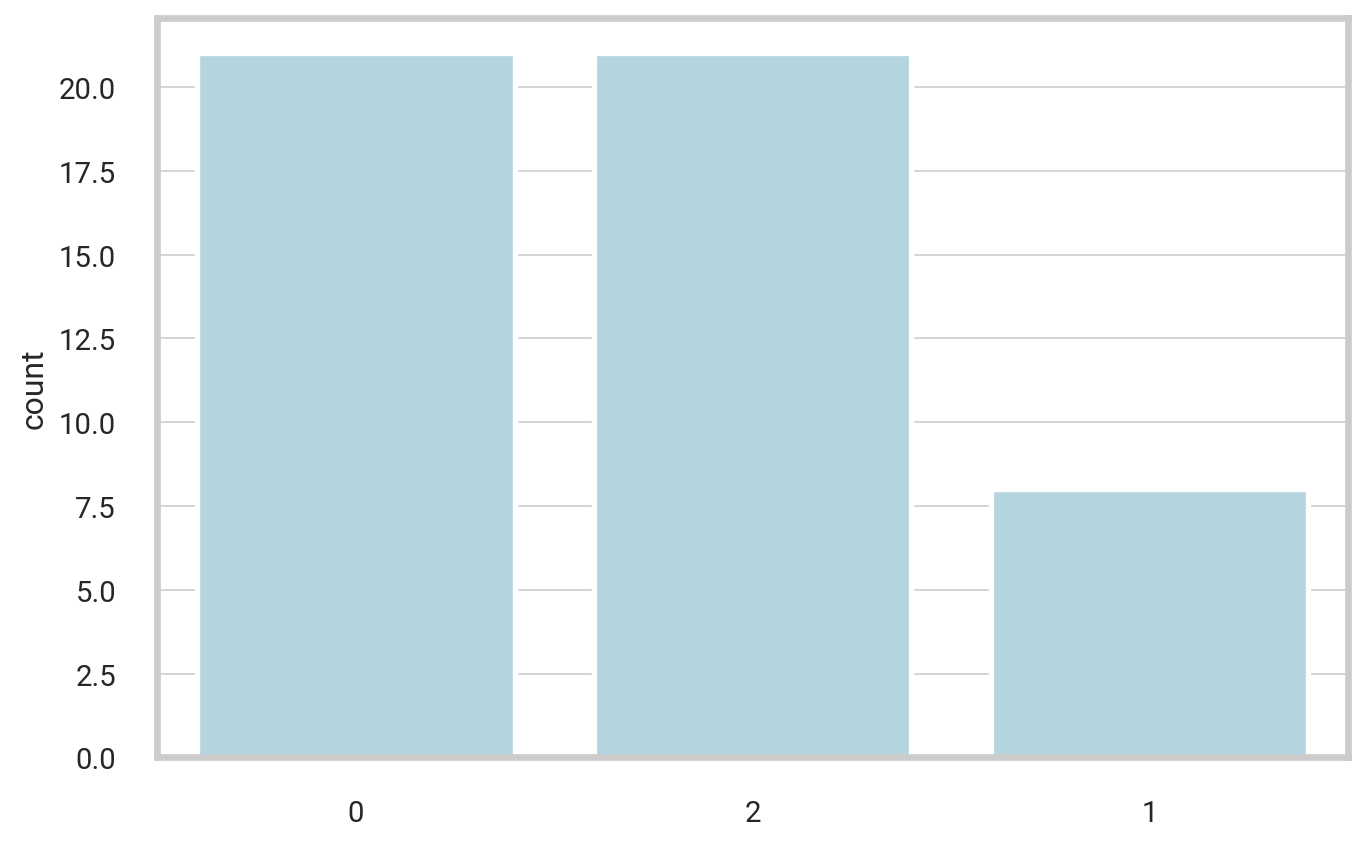

In [49]:
sns.countplot(x=[str(group) for group in kmeans.labels_], color = 'lightblue')

#### Visualizing the Clusters


Moving forward, let's look at differences in the audio features of each group.



In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(playlist_tracks.drop(['artist', 'name'], axis = 1))
scaled_data = scaler.transform(playlist_tracks.drop(['artist', 'name'], axis = 1))

Text(0, 0.5, 'PC2: 0.172')

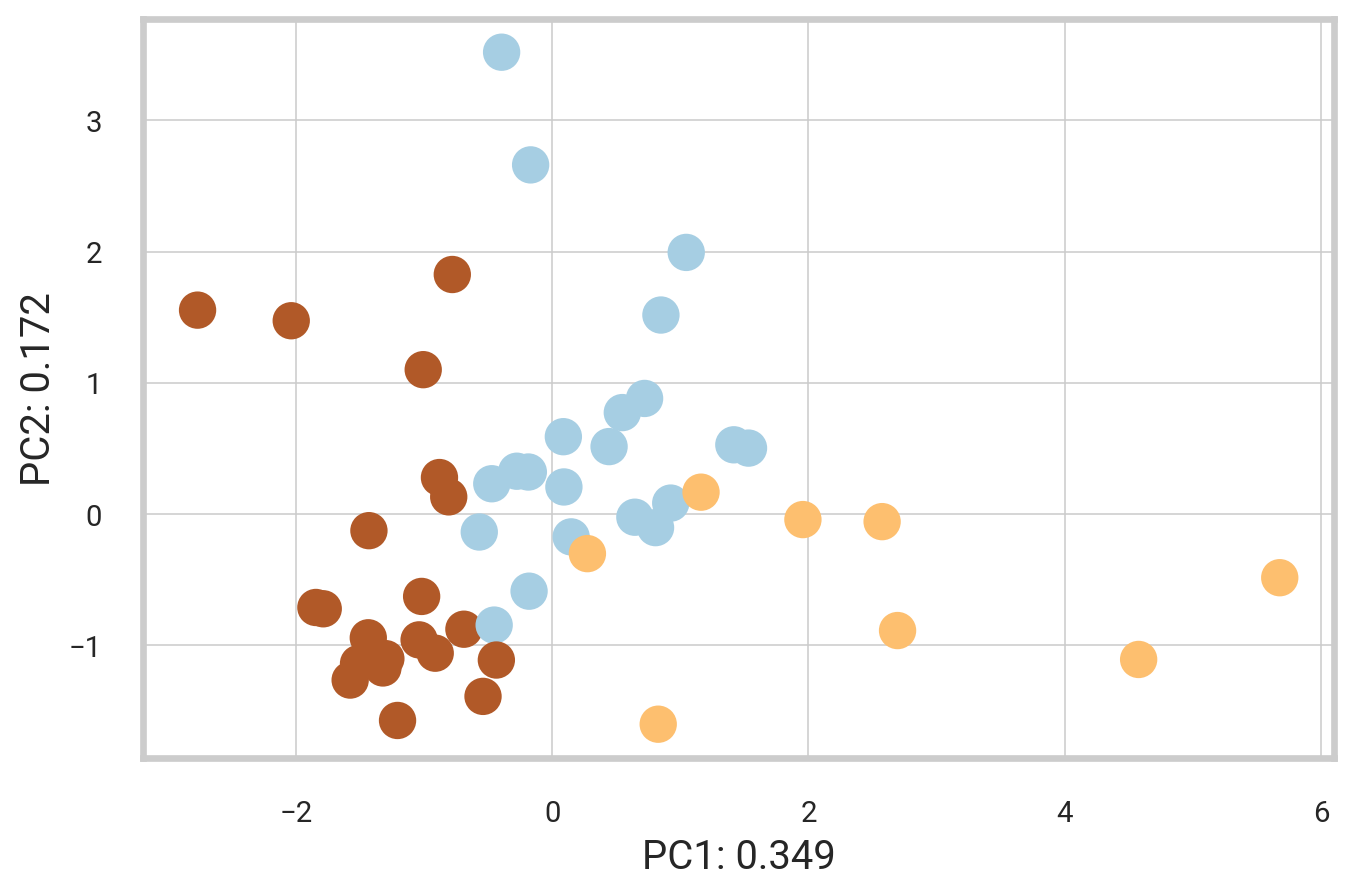

In [51]:
#| code-fold: true

from sklearn.decomposition import PCA
pca = PCA(n_components =2)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)

plt.scatter(data_pca[:,0], data_pca[:,1], c = list(kmeans.labels_), cmap = 'Paired')
plt.xlabel('PC1: {:.3f}'.format(pca.explained_variance_ratio_[0]), size = 15)
plt.ylabel('PC2: {:.3f}'.format(pca.explained_variance_ratio_[1]), size = 15)

Text(0, 0.5, 'PC2: 0.172')

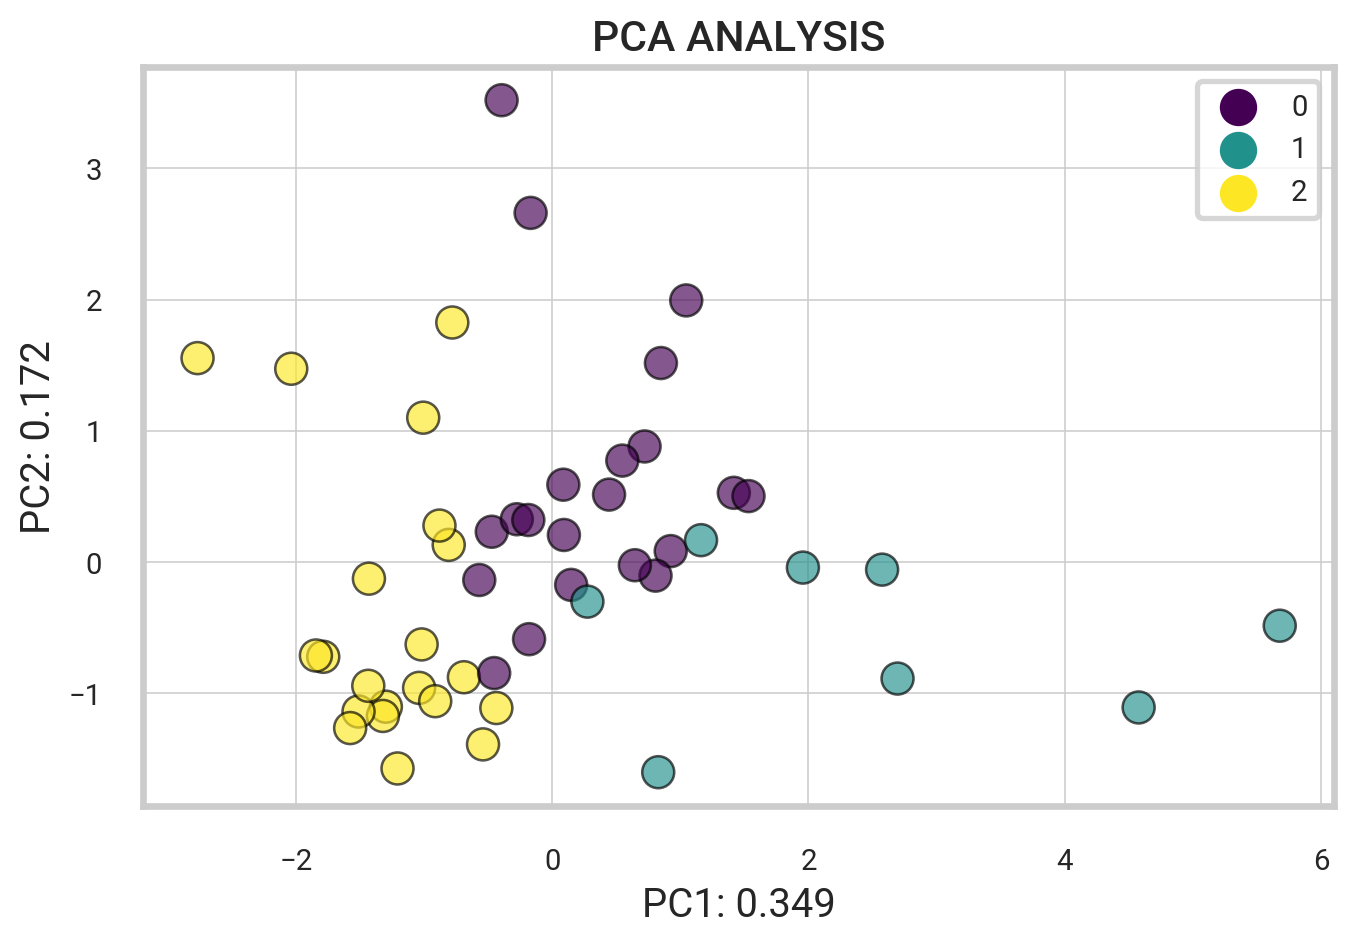

In [52]:
plot = sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue = list(kmeans.labels_),
                       alpha = 0.66, 
                       #size = data_pca[:,1], sizes = (50,200),
                       palette = 'viridis', edgecolor = 'black', cmap='Paired')
plot.set_title('PCA ANALYSIS', size = 16, weight='bold')

plt.xlabel('PC1: {:.3f}'.format(pca.explained_variance_ratio_[0]), size = 15)
plt.ylabel('PC2: {:.3f}'.format(pca.explained_variance_ratio_[1]), size = 15)


In [53]:
playlist_tracks['group'] = list(kmeans.labels_)
playlist_tracks = playlist_tracks.astype({'group': str})

means = pd.DataFrame(index = range(0,3), 
                    columns = list(playlist_tracks[playlist_tracks['group'] == '0'].describe().loc['mean'].index))
means.iloc[0] = playlist_tracks[playlist_tracks['group'] == '0'].describe().loc['mean']
means.iloc[1] = playlist_tracks[playlist_tracks['group'] == '1'].describe().loc['mean']
means.iloc[2] = playlist_tracks[playlist_tracks['group'] == '2'].describe().loc['mean']
means

acousticness danceability    energy  liveness instrumentalness speechiness  \
0     0.131965      0.63481  0.602714  0.181448         0.003759    0.061629   
1      0.73775     0.538875  0.452638  0.127125         0.017273    0.051725   
2      0.11394     0.748381   0.68681   0.14219         0.000761    0.073581   

    valence  
0  0.290567  
1  0.333125  
2  0.746333